In [1]:
import numpy as np 
import pickle 
import h5py
from scipy import stats
from tqdm.auto import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import pandas as pd
from pathlib import Path
import re


%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import src.util_analysis as util_analysis

In [2]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("final_figures/figure_5")
fig_out_dir.mkdir(exist_ok=True, parents=True)

In [11]:
analysis_dir = Path(f"/om/scratch/Fri/imgriff/binaural_unit_activation_analysis/")
all_models = list(analysis_dir.glob("*v10*"))

all_models += list(Path(f"/om/scratch/Thu/imgriff/binaural_unit_activation_analysis/").glob("*v10*"))
models_to_run = []

for path in all_models:
    if not path.is_dir():
        continue
    if 'main' in path.stem and not ('latest' in path.stem  in path.stem):
        continue 
    if 'control' in path.stem:
        continue

    models_to_run.append(path)


model_name_dict = {path.stem: util_analysis.get_model_name(path.stem) for path in models_to_run}


def sort_layers(layers):
    # Separate layers into categories
    coch_layers = ['cochleagram', 'norm_coch_rep']
    fc_layers = ['attnfc', 'relufc']
    n_blocks = len([layer for layer in layers if 'hann_pool' in layer])

    block_order = []
    for block_ix in range(n_blocks):
        block_order.append(f'attn{block_ix}')
        block_order.append(f'conv{block_ix}_ln')
        block_order.append(f'conv{block_ix}_relu')
        block_order.append(f'hann_pool_{block_ix}')

    # Combine all categories in the desired order
    return coch_layers + block_order + fc_layers


In [23]:


# for path in paths:
distractor_conditions = ['same_sex_talker', 'diff_sex_talker',  'natural_scene']

# just look at 0,0 co-located examples 
# wanted_rows = np.where(np.all(target_locs == [0,0], axis=1))[0]
dfs = []

for model_dir in models_to_run:
    # if 'rand' in model_dir.stem and 'main' not in model_dir.stem:
    #     # Skip random models that are not the main model
    #     continue
    if model_dir.stem == 'word_task_v10_main_feature_gain_config_latest_ckpt':
        print("On main model")
    h5_fn = model_dir / f"{model_dir.stem}_model_activations_0dB_diotic_cue_single_source.h5"
    try:
        with h5py.File(h5_fn, 'r', swmr=True) as acts:
            ## Get keys with corr in them 
            # all_act_keys = list(acts.keys())
            layer_names = set([l.split('_target')[0] for l in acts.keys() if 'target' in l and not  any([str_part in l for str_part in ['_f0', '_loc', '_word', 'cued']])]) # set to remove duplicates 
            for layer in layer_names:
                for dist_cond in distractor_conditions:
                    data_dict = {}
                    if dist_cond == 'same_sex_talker':
                        fg_corr_key = f"{layer}_cued_target_mixture_same_corr"
                        bg_corr_key = f"{layer}_cued_same_sex_dist_mixture_same_corr"
                    elif dist_cond == 'diff_sex_talker':
                        fg_corr_key = f"{layer}_cued_target_mixture_diff_corr"
                        bg_corr_key = f"{layer}_cued_diff_sex_dist_mixture_diff_corr"
                    elif dist_cond == 'natural_scene':
                        fg_corr_key = f"{layer}_cued_target_mixture_nat_scene_corr"
                        bg_corr_key = f"{layer}_cued_nat_scene_dist_mixture_nat_scene_corr"   
                    if layer == 'cochleagram':
                        bg_corr_key = bg_corr_key.replace('sex_', '')      
                        fg_corr_key = fg_corr_key.replace('cued_', '')
                        bg_corr_key = bg_corr_key.replace('cued_', '')

                    data_dict['fg_corrs'] = acts[fg_corr_key][:,0]
                    data_dict['bg_corrs'] = acts[bg_corr_key][:,0]
                    N_examples = len(data_dict['fg_corrs'])

                    data_dict['layer'] = [layer] * N_examples
                    data_dict['distractor_condition'] = [dist_cond] * N_examples

                    df = pd.DataFrame(data_dict)
                    df['model_name'] = model_name_dict[h5_fn.parent.name]
                    df['group'] = 'random weights' if 'rand' in h5_fn.parent.name else 'feature-gain'
                    dfs.append(df)
    except Exception as e:
        print(f"Error with {h5_fn}")
        print(e)
        # raise


act_results  = pd.concat(dfs, ignore_index=True)
act_results['layer'] = act_results['layer'].str.replace('_block_', '')

act_results['log_corr_ratio'] = np.log(np.sqrt(act_results['fg_corrs']**2 / act_results['bg_corrs']**2))

act_corrs = pd.melt(act_results[[col for col in act_results.columns if 'cos' not in col]], id_vars =['layer', 'group', 'distractor_condition', 'model_name'], value_vars=['fg_corrs', 'bg_corrs'], var_name='Stream',
                            value_name="Pearson's r")


act_corrs['Stream'].replace('fg_corrs','corr(target$_i$, mixture$_i$)',inplace=True)
act_corrs['Stream'].replace('bg_corrs','corr(distractor$_i$, mixture$_i$)',inplace=True)

act_corrs['distractor_condition'].replace('same_sex_talker','Same sex',inplace=True)
act_corrs['distractor_condition'].replace('diff_sex_talker','Different sex',inplace=True)
act_corrs['distractor_condition'].replace('natural_scene','Natural scene',inplace=True)

act_corrs = act_corrs.drop_duplicates()

Error with /om/scratch/Fri/imgriff/binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_1_rand_weights/word_task_v10_4MGB_ln_first_arch_1_rand_weights_model_activations_0dB_diotic_cue_single_source.h5
[Errno 2] Unable to synchronously open file (unable to open file: name = '/om/scratch/Fri/imgriff/binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_1_rand_weights/word_task_v10_4MGB_ln_first_arch_1_rand_weights_model_activations_0dB_diotic_cue_single_source.h5', errno = 2, error message = 'No such file or directory', flags = 40, o_flags = 0)
Error with /om/scratch/Fri/imgriff/binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_4_rand_weights/word_task_v10_4MGB_ln_first_arch_4_rand_weights_model_activations_0dB_diotic_cue_single_source.h5
[Errno 2] Unable to synchronously open file (unable to open file: name = '/om/scratch/Fri/imgriff/binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_4_rand_weights/word_task_v10_4MGB_ln_first_a

/tmp/ipykernel_259360/1987237115.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  act_corrs['Stream'].replace('fg_corrs','corr(target$_i$, mixture$_i$)',inplace=True)
/tmp/ipykernel_259360/1987237115.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [25]:
act_corrs[act_corrs.model_name == 'Feature-gain main'].layer.unique()

array(['cochleagram', 'conv2_ln', 'hann_pool_4', 'conv6_ln',
       'hann_pool_1', 'hann_pool_3', 'conv1_relu', 'conv4_ln', 'conv3_ln',
       'conv6_relu', 'attnfc', 'attn4', 'attn0', 'hann_pool_2', 'attn6',
       'attn1', 'conv0_ln', 'attn3', 'conv4_relu', 'conv5_relu',
       'conv3_relu', 'norm_coch_rep', 'conv5_ln', 'conv0_relu', 'attn5',
       'hann_pool_6', 'conv2_relu', 'hann_pool_5', 'relufc', 'attn2',
       'conv1_ln', 'hann_pool_0'], dtype=object)

In [26]:
pd.read_pickle("model_architecture_activation_manifests/all_v10_architectures_alts_and_controls.pkl")

{0: {'config_path': PosixPath('config/arch_search/word_task_v10_4MGB_ln_first_arch_1.yaml'),
  'ckpt_path': PosixPath('attn_cue_models/word_task_v10_4MGB_ln_first_arch_1/checkpoints/epoch=2-step=44750-v5.ckpt')},
 1: {'config_path': PosixPath('config/arch_search/word_task_v10_4MGB_ln_first_arch_10.yaml'),
  'ckpt_path': PosixPath('attn_cue_models/word_task_v10_4MGB_ln_first_arch_10/checkpoints/epoch=2-step=33358-v6.ckpt')},
 2: {'config_path': PosixPath('config/arch_search/word_task_v10_4MGB_ln_first_arch_12.yaml'),
  'ckpt_path': PosixPath('attn_cue_models/word_task_v10_4MGB_ln_first_arch_12/checkpoints/epoch=2-step=33358-v5.ckpt')},
 3: {'config_path': PosixPath('config/arch_search/word_task_v10_4MGB_ln_first_arch_2.yaml'),
  'ckpt_path': PosixPath('attn_cue_models/word_task_v10_4MGB_ln_first_arch_2/checkpoints/epoch=3-step=50037-v3.ckpt')},
 4: {'config_path': PosixPath('config/arch_search/word_task_v10_4MGB_ln_first_arch_4.yaml'),
  'ckpt_path': PosixPath('attn_cue_models/word_task

In [27]:
import re
# Get layer order per model. Will have from [cochleagram, norm_coch_rep, ..., attnfc, relufc]
layer_order_dict = {}

def get_int(val):
    return int(re.search(r'\d+', val).group())

for model in act_results['model_name'].unique():
    layers = act_results.loc[act_results['model_name'] == model, 'layer'].unique()
    sorted_layers = sort_layers(layers)
    for layer in sorted_layers:
        if (model == "Computed-gain model" or 'Backbone' in model) and 'attn' in layer:
            sorted_layers.remove(layer)
        if model == 'Late-only':
            if 'attn' in layer and layer != 'attnfc':
                sorted_layers.remove(layer)
        elif model == 'Early-only':
            if 'attn' in layer:
                layer_int = len(layers) if 'fc' in layer else get_int(layer)
                if layer_int > 0:
                    sorted_layers.remove(layer)
    layer_order_dict[model] = sorted_layers


# Main figure



In [28]:
df_for_agg = act_corrs[act_corrs.model_name.str.contains('main|alt') & ~act_corrs.distractor_condition.str.contains('Natural')].copy()
df_for_agg = df_for_agg.groupby(['model_name', 'group', 'layer', 'Stream']).agg({'Pearson\'s r': ['mean', 'sem']}).reset_index()
df_for_agg.columns = ['model_name', 'group', 'layer', 'Stream', 'r', 'r_sem']
df_for_agg = df_for_agg[df_for_agg.layer.str.contains('cochlea|relu')].reset_index(drop=True)

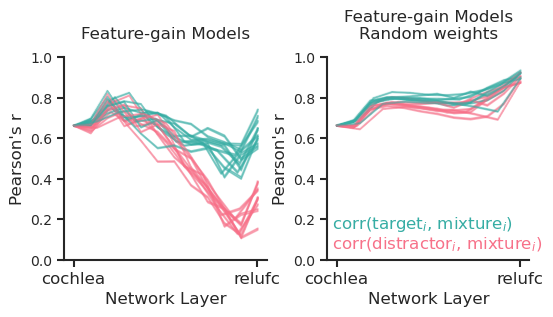

In [31]:
## Plot summary_results df 
sns.set_style('ticks')
# order = np.sort(results.layer.unique())

hue_order = ['corr(target$_i$, mixture$_i$)', 'corr(distractor$_i$, mixture$_i$)'] 
# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'corr(target$_i$, mixture$_i$)': palette[1],
                'corr(distractor$_i$, mixture$_i$)': palette[0],}

# add line style dict 
line_style_dict = {'corr(target$_i$, mixture$_i$)': '-',
                   'corr(distractor$_i$, mixture$_i$)': '-'}  
 
# col_wrap = 6

all_models = act_results['model_name'].unique()
n_models = len(all_models)

n_cols = 2 # trained + rand 
n_rows = 1 # int(np.ceil(n_models / n_cols))
panel_height = 3
fontsize=12
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols* panel_height , n_rows*panel_height), sharex=False, sharey=False)
# axs = axs.flatten()

models = df_for_agg.model_name.unique()


for i, model in enumerate(models):
    axs_ix = 1 if 'rand' in model else 0 
    model_for_panel = df_for_agg[df_for_agg['model_name'] == model].set_index('layer')
    layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
    try:
        model_for_panel = model_for_panel.loc[layers].reset_index()
        x_axis = np.linspace(0, 1, len(layers))
        for stream in model_for_panel.Stream.unique():
            stream_data = model_for_panel[model_for_panel['Stream'] == stream]
            axs[axs_ix].errorbar(x_axis, stream_data['r'], yerr=stream_data['r_sem'], label=stream if i == 0 else None, alpha=0.1, color=palette_dict[stream])
            axs[axs_ix].fill_between(x_axis, stream_data['r'] - stream_data['r_sem'], stream_data['r'] + stream_data['r_sem'], alpha=0.5, color=palette_dict[stream])
    except Exception as e:
        print(f"Error with {model}")
        print(e)
        continue

axs[0].set_title("Feature-gain Models", size=fontsize, y=1.05)
axs[1].set_title("Feature-gain Models\nRandom weights", size=fontsize, y=1.05)
# p.axes[0,0].xaxis.labelpad = -0.25

# axs[1].legend().remove() # (loc='center left', bbox_to_anchor=(1, 0.5), title='Stream', frameon=False, title_fontsize=fontsize)
# make panels square 
for ax in axs:
    ax.set_aspect('auto')
    ax.set_box_aspect(1)
    ax.set_ylim(0, 1)
    # ax.set_xlim(-0.5, len(layers) - 0.5)
    ax.set_xticks([0,1])
    ax.set_xticklabels(labels=['cochlea', 'relufc'], rotation=0, size=fontsize, )
    ax.set(ylim=(0,1))
    ax.set_xlabel("Network Layer", size=fontsize)
    ax.set_ylabel("Pearson's r", size=fontsize)
    # remove spines
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    ax.tick_params(axis='both', which='major', length=5, width=1.5)


# remove legend, and instead plot as colored text 
# axs.legend().remove()
top_y_loc = .175
x_coord = -0.025
axs[1].text(x_coord, top_y_loc, 'corr(target$_i$, mixture$_i$)', ha='left', va='center', fontsize=fontsize, color=palette_dict['corr(target$_i$, mixture$_i$)'])
axs[1].text(x_coord, top_y_loc - .1, 'corr(distractor$_i$, mixture$_i$)', ha='left', va='center', fontsize=fontsize, color=palette_dict['corr(distractor$_i$, mixture$_i$)'])

sns.despine()

# adjust spacing
plt.subplots_adjust(wspace=0.3, hspace=0.3)
# increase size of ticks
# increase size of ticks

# plt.savefig(fig_out_dir / "figure_5_all_arch_traces.pdf", transparent=True, bbox_inches='tight')

# plt.tight_layout()

In [43]:
act_corrs

,layer,group,distractor_condition,model_name,Stream,Pearson's r
0,conv2_ln,random weights,Same sex,Feature-gain alt v10 random weights,"corr(target$_i$, mixture$_i$)",0.927695
1,conv2_ln,random weights,Same sex,Feature-gain alt v10 random weights,"corr(target$_i$, mixture$_i$)",0.831696
2,conv2_ln,random weights,Same sex,Feature-gain alt v10 random weights,"corr(target$_i$, mixture$_i$)",0.882873
3,conv2_ln,random weights,Same sex,Feature-gain alt v10 random weights,"corr(target$_i$, mixture$_i$)",0.906383
4,conv2_ln,random weights,Same sex,Feature-gain alt v10 random weights,"corr(target$_i$, mixture$_i$)",0.855635
...,...,...,...,...,...,...
2936813,relufc,feature-gain,Natural scene,Late-only,"corr(distractor$_i$, mixture$_i$)",0.151669
2936921,relufc,feature-gain,Natural scene,Late-only,"corr(distractor$_i$, mixture$_i$)",0.046930
2936956,relufc,feature-gain,Natural scene,Late-only,"corr(distractor$_i$, mixture$_i$)",0.103405
2936989,relufc,feature-gain,Natural scene,Late-only,"corr(distractor$_i$, mixture$_i$)",0.150522


## Make supplementary figure 5

In [37]:
control_models = ['Early-only', 'Late-only',  "Feature-gain main random weights"]
# nat sort the other archs 
also_sort = [m for m in all_models if m not in control_models and 'computed' not in m and 'rand' not in m and 'main' not in m]
model_order = ['Feature-gain main'] + sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))# + model_order

model_order = [m for m in model_order if m in all_models]

also_sort = [m for m in all_models if 'rand' in m and 'main' not in m and 'alt' in m]
model_order += ['Feature-gain main random weights'] + sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))# + model_order

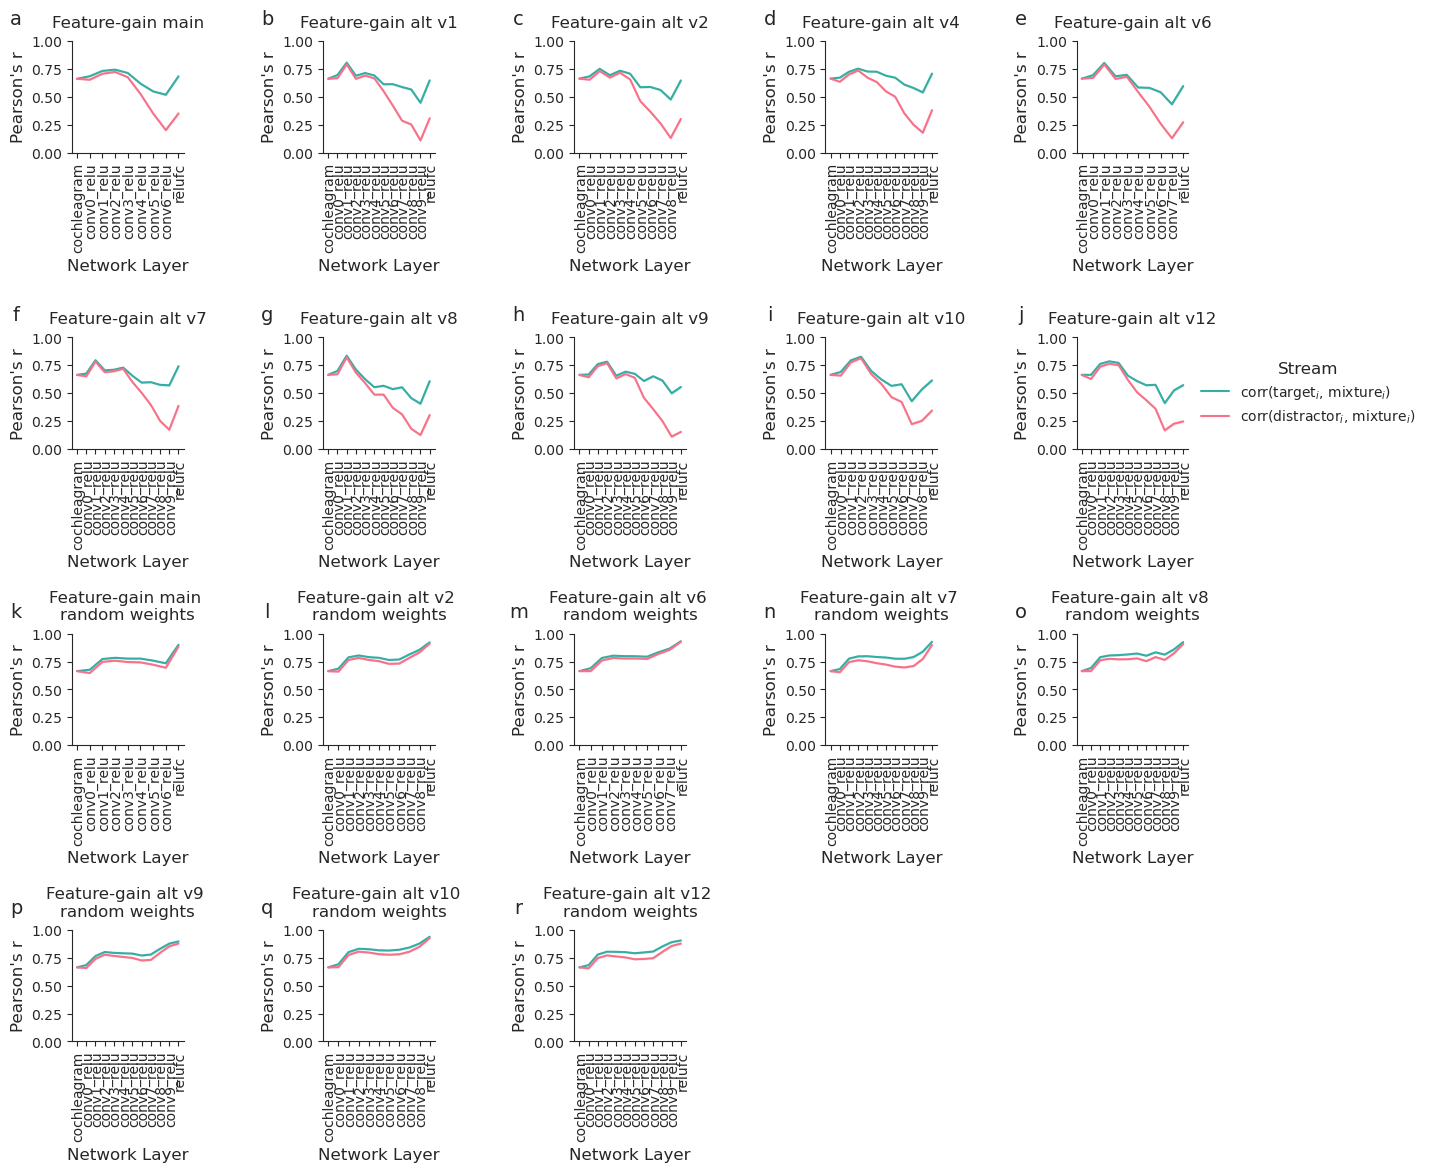

In [42]:
## Plot summary_results df 
sns.set_style('ticks')

hue_order = ['corr(target$_i$, mixture$_i$)', 'corr(distractor$_i$, mixture$_i$)'] 
# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'corr(target$_i$, mixture$_i$)': palette[1],
                'corr(distractor$_i$, mixture$_i$)': palette[0],}

# add line style dict 
line_style_dict = {'corr(target$_i$, mixture$_i$)': '-',
                   'corr(distractor$_i$, mixture$_i$)': '-'}  
 
col_wrap = 6

all_models = act_results['model_name'].unique()
control_models = ['Early-only', 'Late-only',  "Feature-gain main random weights"]
# nat sort the other archs 
also_sort = [m for m in all_models if m not in control_models and 'computed' not in m and 'rand' not in m and 'main' not in m]
model_order = ['Feature-gain main'] + sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))# + model_order

model_order = [m for m in model_order if m in all_models]

# add random models 
also_sort = [m for m in all_models if m not in model_order and 'computed' not in m and 'rand' in m and 'main' not in m and 'alt' in m]
model_order += ['Feature-gain main random weights'] + sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))# + model_order


n_models = len(model_order)

n_cols = 5
n_rows = 4 
panel_height = 3
fontsize=12

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols* panel_height , n_rows*panel_height), sharex=False, sharey=False)
axs = axs.flatten()

to_plot = act_corrs[(~act_corrs.distractor_condition.str.contains('Natural'))].copy()

legend_panel = 9
ratio=1
for i, model in enumerate(model_order):
    model_for_panel = to_plot[to_plot['model_name'] == model].set_index('layer')
    layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
    model_for_panel = model_for_panel.loc[layers].reset_index()

    g = sns.lineplot(data=model_for_panel, x='layer', 
                     y="Pearson's r", hue='Stream', ax=axs[i],
                     palette=palette_dict,  hue_order=hue_order,
                     errorbar=('se', 1)
                    )

    axs[i].set_xlabel("Network Layer", size=fontsize)
    axs[i].set_ylabel("Pearson's r", size=fontsize)
    if 'random' in model:
        axs[i].set_title(model.replace('random', '\nrandom'), size=fontsize, y=1.05)
    else:
        axs[i].set_title(model, size=fontsize, y=1.05)
    # set y limit to 0,1
    axs[i].set(ylim=(0,1))

    if i != legend_panel:
        axs[i].legend().remove()

    axs[i].set_xticks(range(len(layers)))
    axs[i].set_xticklabels(labels=layers, rotation=90,  #size=tick_fontsize, 
                           ha='right', va='center_baseline',  rotation_mode='anchor')
    ax = axs[i]
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

axs[legend_panel].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Stream', frameon=False, title_fontsize=fontsize)

sns.despine()
for ix, ax in enumerate(axs.ravel()):
    if ix >= n_models:
        ax.axis('off')

for ix, ax in enumerate(axs):
    if ix < n_models:
        ax.text(-0.5, 1.2, f'{chr(97+ix)}', transform=ax.transAxes, fontsize=fontsize+2, va='center', ha='center')

ratio = 1 
# make e

plt.tight_layout()
# plt.savefig(fig_out_dir / "supplementary_fig_5.pdf", transparent=True, bbox_inches='tight')


In [15]:
model_order

['Feature-gain main',
 'Feature-gain alt v1',
 'Feature-gain alt v2',
 'Feature-gain alt v4',
 'Feature-gain alt v6',
 'Feature-gain alt v7',
 'Feature-gain alt v8',
 'Feature-gain alt v9',
 'Feature-gain alt v10',
 'Feature-gain alt v12',
 'Feature-gain main random weights',
 'Feature-gain alt v2 random weights',
 'Feature-gain alt v6 random weights',
 'Feature-gain alt v7 random weights',
 'Feature-gain alt v8 random weights',
 'Feature-gain alt v9 random weights',
 'Feature-gain alt v10 random weights',
 'Feature-gain alt v12 random weights',
 'Feature-gain main',
 'Feature-gain alt v1',
 'Feature-gain alt v2',
 'Feature-gain alt v4',
 'Feature-gain alt v6',
 'Feature-gain alt v7',
 'Feature-gain alt v8',
 'Feature-gain alt v9',
 'Feature-gain alt v10',
 'Feature-gain alt v12',
 'Feature-gain main random weights',
 'Feature-gain alt v2 random weights',
 'Feature-gain alt v6 random weights',
 'Feature-gain alt v7 random weights',
 'Feature-gain alt v8 random weights',
 'Feature-gain 

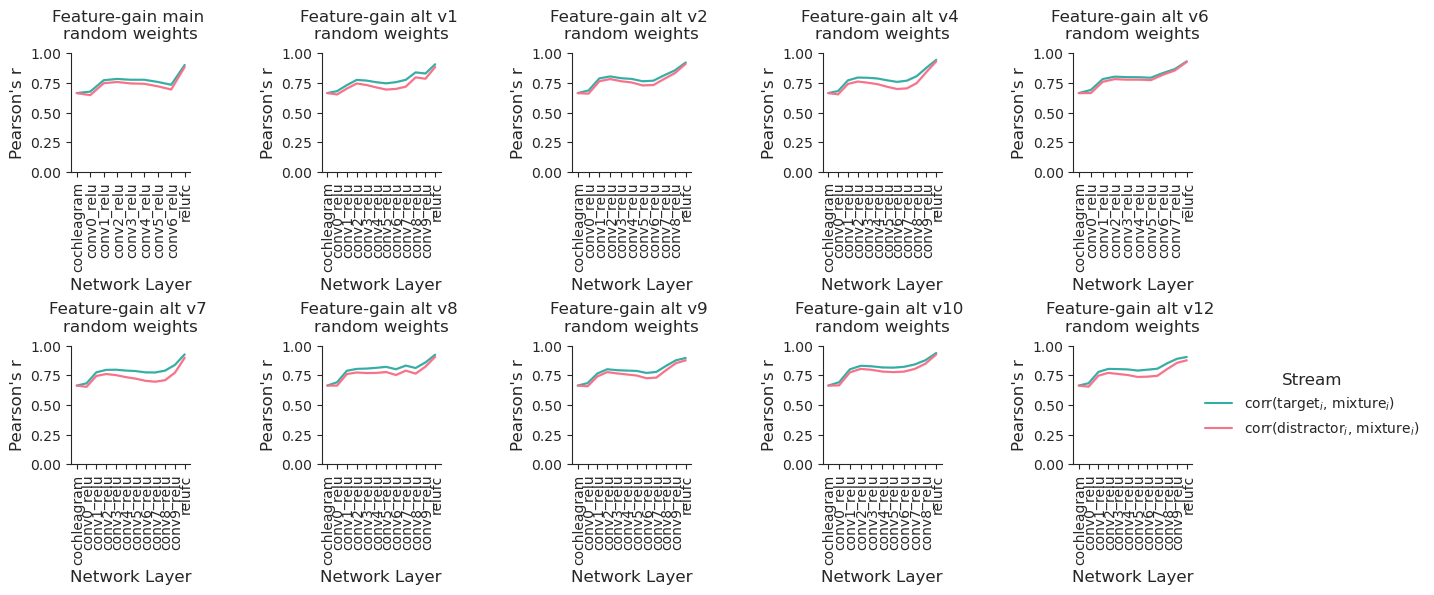

In [37]:
## Plot summary_results df 
sns.set_style('ticks')
# order = np.sort(results.layer.unique())

hue_order = ['corr(target$_i$, mixture$_i$)', 'corr(distractor$_i$, mixture$_i$)'] 
# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'corr(target$_i$, mixture$_i$)': palette[1],
                'corr(distractor$_i$, mixture$_i$)': palette[0],}

# add line style dict 
line_style_dict = {'corr(target$_i$, mixture$_i$)': '-',
                   'corr(distractor$_i$, mixture$_i$)': '-'}  
 
col_wrap = 6

all_models = act_results['model_name'].unique()

# n_cols = 4
# n_rows = int(np.ceil(n_models / n_cols))
# panel_height = 3
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols* panel_height , n_rows*panel_height), sharex=False, sharey=False)
# axs = axs.flatten()

# nat sort the other archs 
also_sort = [m for m in all_models if m not in model_order and 'computed' not in m and 'rand' in m and 'main' not in m and 'alt' in m]
model_order = ['Feature-gain main random weights'] + sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))# + model_order

model_order = [m for m in model_order if m in all_models]

n_models = len(model_order)

n_cols = 5
n_rows = int(np.ceil(n_models / n_cols))
panel_height = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols* panel_height , n_rows*panel_height), sharex=False, sharey=False)
axs = axs.flatten()

to_plot = act_corrs[(~act_corrs.distractor_condition.str.contains('Natural'))].copy()

legend_panel = 9
ratio=1
for i, model in enumerate(model_order):
    model_for_panel = to_plot[to_plot['model_name'] == model].set_index('layer')
    layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
    model_for_panel = model_for_panel.loc[layers].reset_index()

    g = sns.lineplot(data=model_for_panel, x='layer', 
                     y="Pearson's r", hue='Stream', ax=axs[i],
                     palette=palette_dict,  hue_order=hue_order,
                     errorbar=('se', 1)
                    )

    axs[i].set_xlabel("Network Layer", size=fontsize)
    axs[i].set_ylabel("Pearson's r", size=fontsize)
    axs[i].set_title(model.replace('random', '\nrandom'), size=fontsize, y=1.05)
    # p.axes[0,0].xaxis.labelpad = -0.25
    # set y limit to 0,1
    axs[i].set(ylim=(0,1))

    if i != legend_panel:
        axs[i].legend().remove()

    axs[i].set_xticks(range(len(layers)))
    axs[i].set_xticklabels(labels=layers, rotation=90,  #size=tick_fontsize, 
                           ha='right', va='center_baseline',  rotation_mode='anchor')
    ax = axs[i]
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

axs[legend_panel].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Stream', frameon=False, title_fontsize=fontsize)

sns.despine()
for ix, ax in enumerate(axs.ravel()):
    if ix >= n_models:
        ax.axis('off')

ratio = 1 
# make e

plt.tight_layout()

### Old plots

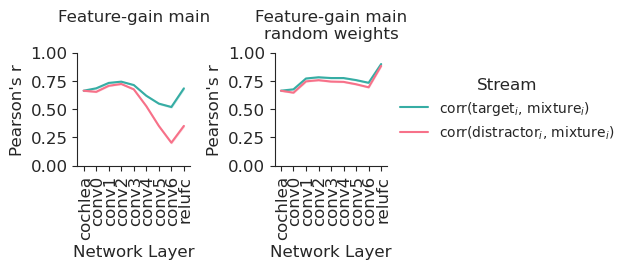

In [15]:
## Plot summary_results df 
sns.set_style('ticks')
# order = np.sort(results.layer.unique())

hue_order = ['corr(target$_i$, mixture$_i$)', 'corr(distractor$_i$, mixture$_i$)'] 
# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'corr(target$_i$, mixture$_i$)': palette[1],
                'corr(distractor$_i$, mixture$_i$)': palette[0],}

# add line style dict 
line_style_dict = {'corr(target$_i$, mixture$_i$)': '-',
                   'corr(distractor$_i$, mixture$_i$)': '-'}  
 
col_wrap = 6

all_models = act_results['model_name'].unique()
n_models = len(all_models)

model_order = ['Feature-gain main', "Feature-gain main random weights"]
panel_titles = {'Feature-gain main': "Feature-gain main\n",  "Feature-gain main random weights":"Feature-gain main\nrandom weights"}
n_cols = len(model_order)
n_rows = 1 # int(np.ceil(n_models / n_cols))
panel_height = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * panel_height , n_rows*panel_height), sharex=False, sharey=False)
axs = axs.flatten()

# model_order = ['Feature-gain main', 'Early-only','Late-only', "Feature-gain main random weights"]

# nat sort the other archs 
# also_sort = [m for m in all_models if m not in model_order]
# model_order += sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))

# model_order = [m for m in model_order if m in all_models]

to_plot = act_corrs[(~act_corrs.distractor_condition.str.contains('Natural'))].copy()

legend_panel = n_cols - 1
y_ticks = np.linspace(0,1, 5)
for i, model in enumerate(model_order):
    model_for_panel = to_plot[to_plot['model_name'] == model].set_index('layer')
    layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
    model_for_panel = model_for_panel.loc[layers].reset_index()
    layer_names = ['cochlea' if 'cochlea' in l else l.split('_')[0] for l in layers]

    g = sns.lineplot(data=model_for_panel, x='layer', 
                     y="Pearson's r", hue='Stream', ax=axs[i],
                     palette=palette_dict,  hue_order=hue_order,
                     errorbar=('se', 1)
                    )

    axs[i].set_xlabel("Network Layer", size=fontsize)
    axs[i].set_ylabel("Pearson's r", size=fontsize)
    axs[i].set_title(panel_titles[model], size=fontsize, y=1.05)
    # p.axes[0,0].xaxis.labelpad = -0.25
    # set y limit to 0,1
    axs[i].set(ylim=(0,1))

    if i != legend_panel:
        axs[i].legend().remove()

    axs[i].set_xticks(range(len(layers)))
    axs[i].set_xticklabels(labels=layer_names, rotation=90, size=fontsize, 
                           ha='right', va='center_baseline',  rotation_mode='anchor')
    axs[i].set_yticks(y_ticks)
    axs[i].set_yticklabels(labels=[f"{tick:.2f}" for tick in y_ticks], size=fontsize)

axs[legend_panel].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Stream', frameon=False, title_fontsize=fontsize)

# increase spacing between panels 
plt.subplots_adjust(wspace=0.75)

# make panels square 
for ax in axs:
    ax.set_aspect('auto')
    ax.set_box_aspect(1)
    # ax.set_ylim(0, 1)
    ax.set_xlim(-0.5, len(layers) - 0.5)
    # remove spines

sns.despine()
for ix, ax in enumerate(axs.ravel()):
    if ix >= n_models:
        ax.axis('off')

# plt.tight_layout()

## Main models

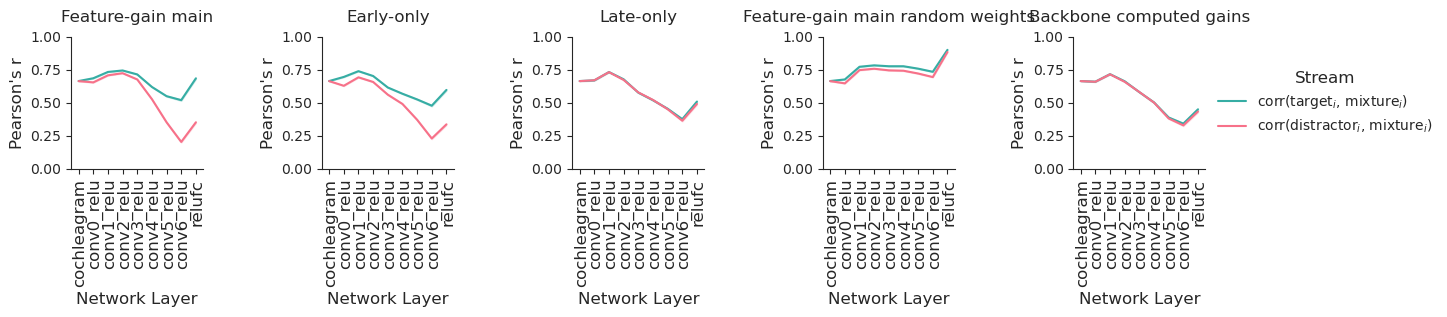

In [16]:
## Plot summary_results df 
sns.set_style('ticks')
# order = np.sort(results.layer.unique())

hue_order = ['corr(target$_i$, mixture$_i$)', 'corr(distractor$_i$, mixture$_i$)'] 
# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'corr(target$_i$, mixture$_i$)': palette[1],
                'corr(distractor$_i$, mixture$_i$)': palette[0],}

# add line style dict 
line_style_dict = {'corr(target$_i$, mixture$_i$)': '-',
                   'corr(distractor$_i$, mixture$_i$)': '-'}  
 
col_wrap = 6

all_models = act_results['model_name'].unique()
n_models = len(all_models)

n_cols = 5
n_rows = 1 # int(np.ceil(n_models / n_cols))
panel_height = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols* panel_height , n_rows*panel_height), sharex=False, sharey=False)
axs = axs.flatten()

# model_order = ['Feature-gain main', 'Early-only','Late-only', "Feature-gain main random weights"]
model_order = ['Feature-gain main', 'Early-only','Late-only', "Feature-gain main random weights", "Backbone computed gains"]

# nat sort the other archs 
# also_sort = [m for m in all_models if m not in model_order]
# model_order += sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))

# model_order = [m for m in model_order if m in all_models]

to_plot = act_corrs[(~act_corrs.distractor_condition.str.contains('Natural'))].copy()

legend_panel = n_cols - 1

for i, model in enumerate(model_order):
    model_for_panel = to_plot[to_plot['model_name'] == model].set_index('layer')
    layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
    model_for_panel = model_for_panel.loc[layers].reset_index()

    g = sns.lineplot(data=model_for_panel, x='layer', 
                     y="Pearson's r", hue='Stream', ax=axs[i],
                     palette=palette_dict,  hue_order=hue_order,
                     errorbar=('se', 1)
                    )

    axs[i].set_xlabel("Network Layer", size=fontsize)
    axs[i].set_ylabel("Pearson's r", size=fontsize)
    axs[i].set_title(model, size=fontsize, y=1.05)
    # p.axes[0,0].xaxis.labelpad = -0.25
    # set y limit to 0,1
    axs[i].set(ylim=(0,1))

    if i != legend_panel:
        axs[i].legend().remove()

    axs[i].set_xticks(range(len(layers)))
    axs[i].set_xticklabels(labels=layers, rotation=90, size=fontsize, 
                           ha='right', va='center_baseline',  rotation_mode='anchor')

axs[legend_panel].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Stream', frameon=False, title_fontsize=fontsize)

# make panels square 
for ax in axs:
    ax.set_aspect('auto')
    ax.set_box_aspect(1)
    ax.set_ylim(0, 1)
    ax.set_xlim(-0.5, len(layers) - 0.5)
    # remove spines

sns.despine()
for ix, ax in enumerate(axs.ravel()):
    if ix >= n_models:
        ax.axis('off')

plt.tight_layout()

# Make panel for supplement, overlaying alternate architectures on same figure 

In [17]:
act_corrs

,layer,group,distractor_condition,model_name,Stream,Pearson's r
0,conv8_relu,random weights,Same sex,Feature-gain alt v10 random weights,"corr(target$_i$, mixture$_i$)",0.954982
1,conv8_relu,random weights,Same sex,Feature-gain alt v10 random weights,"corr(target$_i$, mixture$_i$)",0.932233
2,conv8_relu,random weights,Same sex,Feature-gain alt v10 random weights,"corr(target$_i$, mixture$_i$)",0.951518
3,conv8_relu,random weights,Same sex,Feature-gain alt v10 random weights,"corr(target$_i$, mixture$_i$)",0.953292
4,conv8_relu,random weights,Same sex,Feature-gain alt v10 random weights,"corr(target$_i$, mixture$_i$)",0.905205
...,...,...,...,...,...,...
2843995,attn1,random weights,Natural scene,Feature-gain alt v9 random weights,"corr(distractor$_i$, mixture$_i$)",0.907627
2843996,attn1,random weights,Natural scene,Feature-gain alt v9 random weights,"corr(distractor$_i$, mixture$_i$)",0.864579
2843997,attn1,random weights,Natural scene,Feature-gain alt v9 random weights,"corr(distractor$_i$, mixture$_i$)",0.822964
2843998,attn1,random weights,Natural scene,Feature-gain alt v9 random weights,"corr(distractor$_i$, mixture$_i$)",0.861623


In [18]:
df_for_agg = act_corrs[act_corrs.model_name.str.contains('main|alt') & ~act_corrs.distractor_condition.str.contains('Natural') & ~act_corrs.model_name.str.contains('random')].copy()
df_for_agg = df_for_agg.groupby(['model_name', 'layer', 'Stream']).agg({'Pearson\'s r': ['mean', 'sem']}).reset_index()
df_for_agg.columns = ['model_name', 'layer', 'Stream', 'r', 'r_sem']
df_for_agg = df_for_agg[df_for_agg.layer.str.contains('cochlea|relu')].reset_index(drop=True)

In [19]:
df_for_agg.model_name.unique()

array(['Feature-gain alt v1', 'Feature-gain alt v10',
       'Feature-gain alt v12', 'Feature-gain alt v2',
       'Feature-gain alt v4', 'Feature-gain alt v6',
       'Feature-gain alt v7', 'Feature-gain alt v8',
       'Feature-gain alt v9', 'Feature-gain main'], dtype=object)

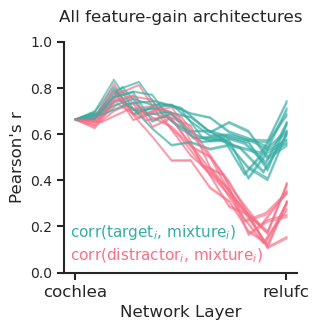

In [20]:
## Plot summary_results df 
sns.set_style('ticks')
# order = np.sort(results.layer.unique())

hue_order = ['corr(target$_i$, mixture$_i$)', 'corr(distractor$_i$, mixture$_i$)'] 
# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'corr(target$_i$, mixture$_i$)': palette[1],
                'corr(distractor$_i$, mixture$_i$)': palette[0],}

# add line style dict 
line_style_dict = {'corr(target$_i$, mixture$_i$)': '-',
                   'corr(distractor$_i$, mixture$_i$)': '-'}  
 
# col_wrap = 6

all_models = act_results['model_name'].unique()
n_models = len(all_models)

n_cols = 1
n_rows = 1 # int(np.ceil(n_models / n_cols))
panel_height = 3
fontsize=12
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols* panel_height , n_rows*panel_height), sharex=False, sharey=False)
# axs = axs.flatten()

models = df_for_agg.model_name.unique()


for i, model in enumerate(models):
    model_for_panel = df_for_agg[df_for_agg['model_name'] == model].set_index('layer')
    layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
    model_for_panel = model_for_panel.loc[layers].reset_index()
    x_axis = np.linspace(0, 1, len(layers))
    for stream in model_for_panel.Stream.unique():
        stream_data = model_for_panel[model_for_panel['Stream'] == stream]
        axs.errorbar(x_axis, stream_data['r'], yerr=stream_data['r_sem'], label=stream if i == 0 else None, alpha=0.1, color=palette_dict[stream])
        axs.fill_between(x_axis, stream_data['r'] - stream_data['r_sem'], stream_data['r'] + stream_data['r_sem'], alpha=0.5, color=palette_dict[stream])



axs.set_xlabel("Network Layer", size=fontsize)
axs.set_ylabel("Pearson's r", size=fontsize)
axs.set_title("All feature-gain architectures", size=fontsize, y=1.05)
# p.axes[0,0].xaxis.labelpad = -0.25
# set y limit to 0,1
axs.set(ylim=(0,1))

# if i != legend_panel:
#     axs.legend().remove()

axs.set_xticks([0,1])
axs.set_xticklabels(labels=['cochlea', 'relufc'], rotation=0, size=fontsize, )
                        # ha='right', va='center_baseline', 
                        #   rotation_mode='anchor')

axs.legend().remove() # (loc='center left', bbox_to_anchor=(1, 0.5), title='Stream', frameon=False, title_fontsize=fontsize)

# make panels square 
# for ax in axs:
ax.set_aspect('auto')
ax.set_box_aspect(1)
ax.set_ylim(0, 1)
ax.set_xlim(-0.5, len(layers) - 0.5)
    # remove spines

# remove legend, and instead plot as colored text 
# axs.legend().remove()
top_y_loc = .175
x_coord = -0.025
axs.text(x_coord, top_y_loc, 'corr(target$_i$, mixture$_i$)', ha='left', va='center', fontsize=fontsize-1, color=palette_dict['corr(target$_i$, mixture$_i$)'])
axs.text(x_coord, top_y_loc - .1, 'corr(distractor$_i$, mixture$_i$)', ha='left', va='center', fontsize=fontsize-1, color=palette_dict['corr(distractor$_i$, mixture$_i$)'])

sns.despine()
# for ix, ax in enumerate(axs.ravel()):
#     if ix >= n_models:
#         ax.axis('off')
#
# increase thickness of spines
for spine in axs.spines.values():
    spine.set_linewidth(1.5)
# increase size of ticks
axs.tick_params(axis='both', which='major', length=5, width=1.5)
# increase size of ticks


# plt.tight_layout()

### All models

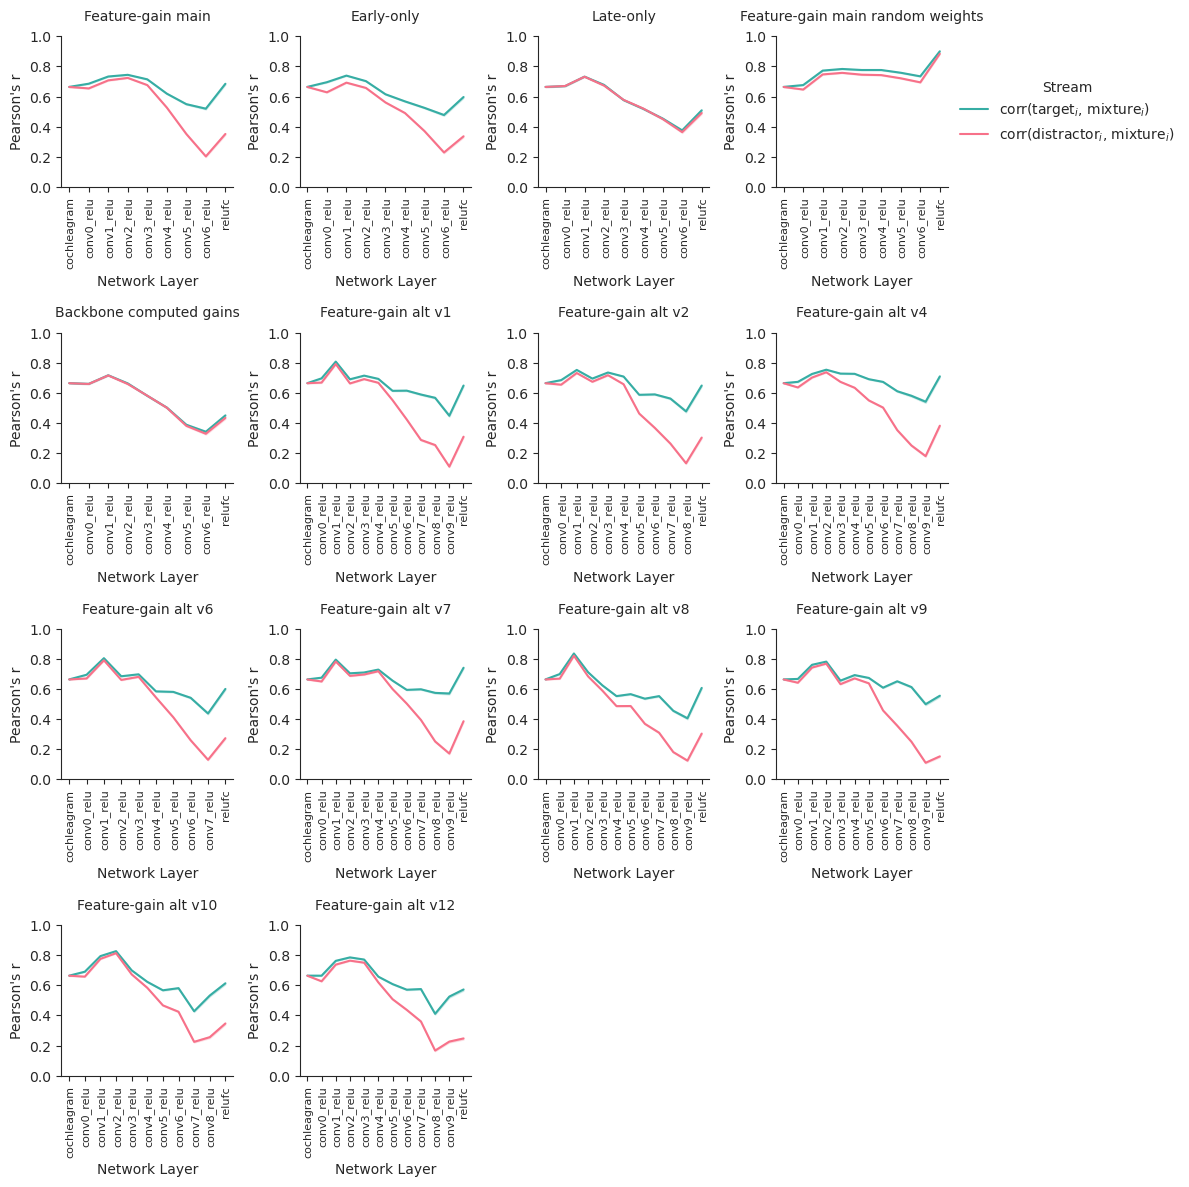

In [ ]:
## Plot summary_results df 
sns.set_style('ticks')
# order = np.sort(results.layer.unique())

hue_order = ['corr(target$_i$, mixture$_i$)', 'corr(distractor$_i$, mixture$_i$)'] 
# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'corr(target$_i$, mixture$_i$)': palette[1],
                'corr(distractor$_i$, mixture$_i$)': palette[0],}

# add line style dict 
line_style_dict = {'corr(target$_i$, mixture$_i$)': '-',
                   'corr(distractor$_i$, mixture$_i$)': '-'}  
 
col_wrap = 6

all_models = act_results['model_name'].unique()
n_models = len(all_models)

n_cols = 4
n_rows = int(np.ceil(n_models / n_cols))
panel_height = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols* panel_height , n_rows*panel_height), sharex=False, sharey=False)
axs = axs.flatten()

model_order = ['Feature-gain main', 'Early-only', 'Late-only', "Feature-gain main random weights", "Backbone computed gains"]
# nat sort the other archs 
also_sort = [m for m in all_models if m not in model_order]
model_order += sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))

model_order = [m for m in model_order if m in all_models]

to_plot = act_corrs[(~act_corrs.distractor_condition.str.contains('Natural'))].copy()

legend_panel = 3

for i, model in enumerate(model_order):
    model_for_panel = to_plot[to_plot['model_name'] == model].set_index('layer')
    layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
    model_for_panel = model_for_panel.loc[layers].reset_index()

    g = sns.lineplot(data=model_for_panel, x='layer', 
                     y="Pearson's r", hue='Stream', ax=axs[i],
                     palette=palette_dict,  hue_order=hue_order,
                     errorbar=('se', 1)
                    )

    axs[i].set_xlabel("Network Layer", size=fontsize)
    axs[i].set_ylabel("Pearson's r", size=fontsize)
    axs[i].set_title(model, size=fontsize, y=1.05)
    # p.axes[0,0].xaxis.labelpad = -0.25
    # set y limit to 0,1
    axs[i].set(ylim=(0,1))

    if i != legend_panel:
        axs[i].legend().remove()

    axs[i].set_xticks(range(len(layers)))
    axs[i].set_xticklabels(labels=layers, rotation=90, size=tick_fontsize, 
                           ha='right', va='center_baseline',  rotation_mode='anchor')

axs[legend_panel].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Stream', frameon=False, title_fontsize=fontsize)

sns.despine()
for ix, ax in enumerate(axs.ravel()):
    if ix >= n_models:
        ax.axis('off')

plt.tight_layout()

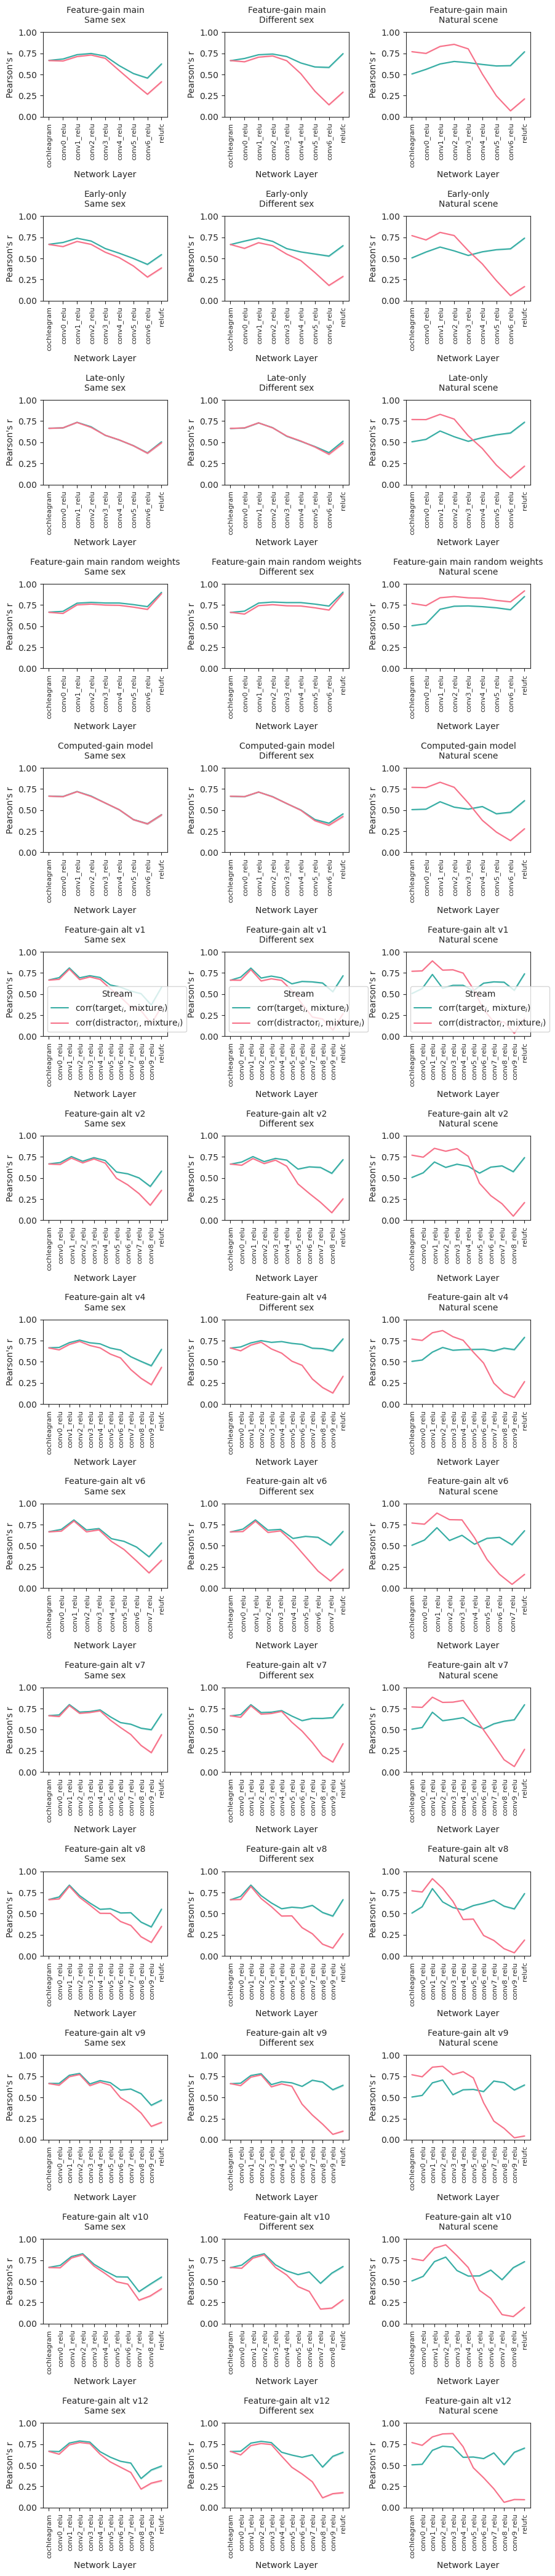

In [26]:
## Plot summary_results df 
sns.set_style('ticks')
# order = np.sort(results.layer.unique())

hue_order = ['corr(target$_i$, mixture$_i$)', 'corr(distractor$_i$, mixture$_i$)'] 
distractor_condition = ['Same sex', 'Different sex', 'Natural scene']
# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'corr(target$_i$, mixture$_i$)': palette[1],
                'corr(distractor$_i$, mixture$_i$)': palette[0],}

# add line style dict 
line_style_dict = {'corr(target$_i$, mixture$_i$)': '-',
                   'corr(distractor$_i$, mixture$_i$)': '-'}  
 
col_wrap = 3 

all_models = act_results['model_name'].unique()
n_models = len(all_models)

n_cols = 3 
n_rows = n_models # int(np.ceil(n_models))
panel_height = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols* panel_height , n_rows*panel_height), sharex=False, sharey=False)
# axs = axs.flatten()

model_order = ['Feature-gain main', 'Early-only','Late-only', "Feature-gain main random weights", "Computed-gain model"]
# nat sort the other archs 
also_sort = [m for m in all_models if m not in model_order]
model_order += sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))

model_order = [m for m in model_order if m in all_models]

for i, model in enumerate(model_order):
    for j, condition in enumerate(distractor_condition):
        to_plot = act_corrs[(act_corrs['model_name'] == model) & (act_corrs['distractor_condition'] == condition)].set_index('layer')
        layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
        to_plot = to_plot.loc[layers].reset_index()

        g = sns.lineplot(data=to_plot, x='layer', 
                        y="Pearson's r", hue='Stream', ax=axs[i, j],
                        palette=palette_dict,  hue_order=hue_order,
                        errorbar=('se', 1)
                        )

        axs[i, j].set_xlabel("Network Layer", size=fontsize)
        axs[i, j].set_ylabel("Pearson's r", size=fontsize)
        axs[i, j].set_title(f"{model}\n{condition}", size=fontsize, y=1.05)
        # p.axes[0,0].xaxis.labelpad = -0.25
        # set y limit to 0,1
        axs[i, j].set(ylim=(0,1))

        if i != 5:
            axs[i, j].legend().remove()

        axs[i, j].set_xticks(range(len(layers)))
        axs[i, j].set_xticklabels(labels=layers, rotation=90, size=tick_fontsize, 
                            ha='right', va='center_baseline',  rotation_mode='anchor')


plt.tight_layout()

### Plot difference between streams 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


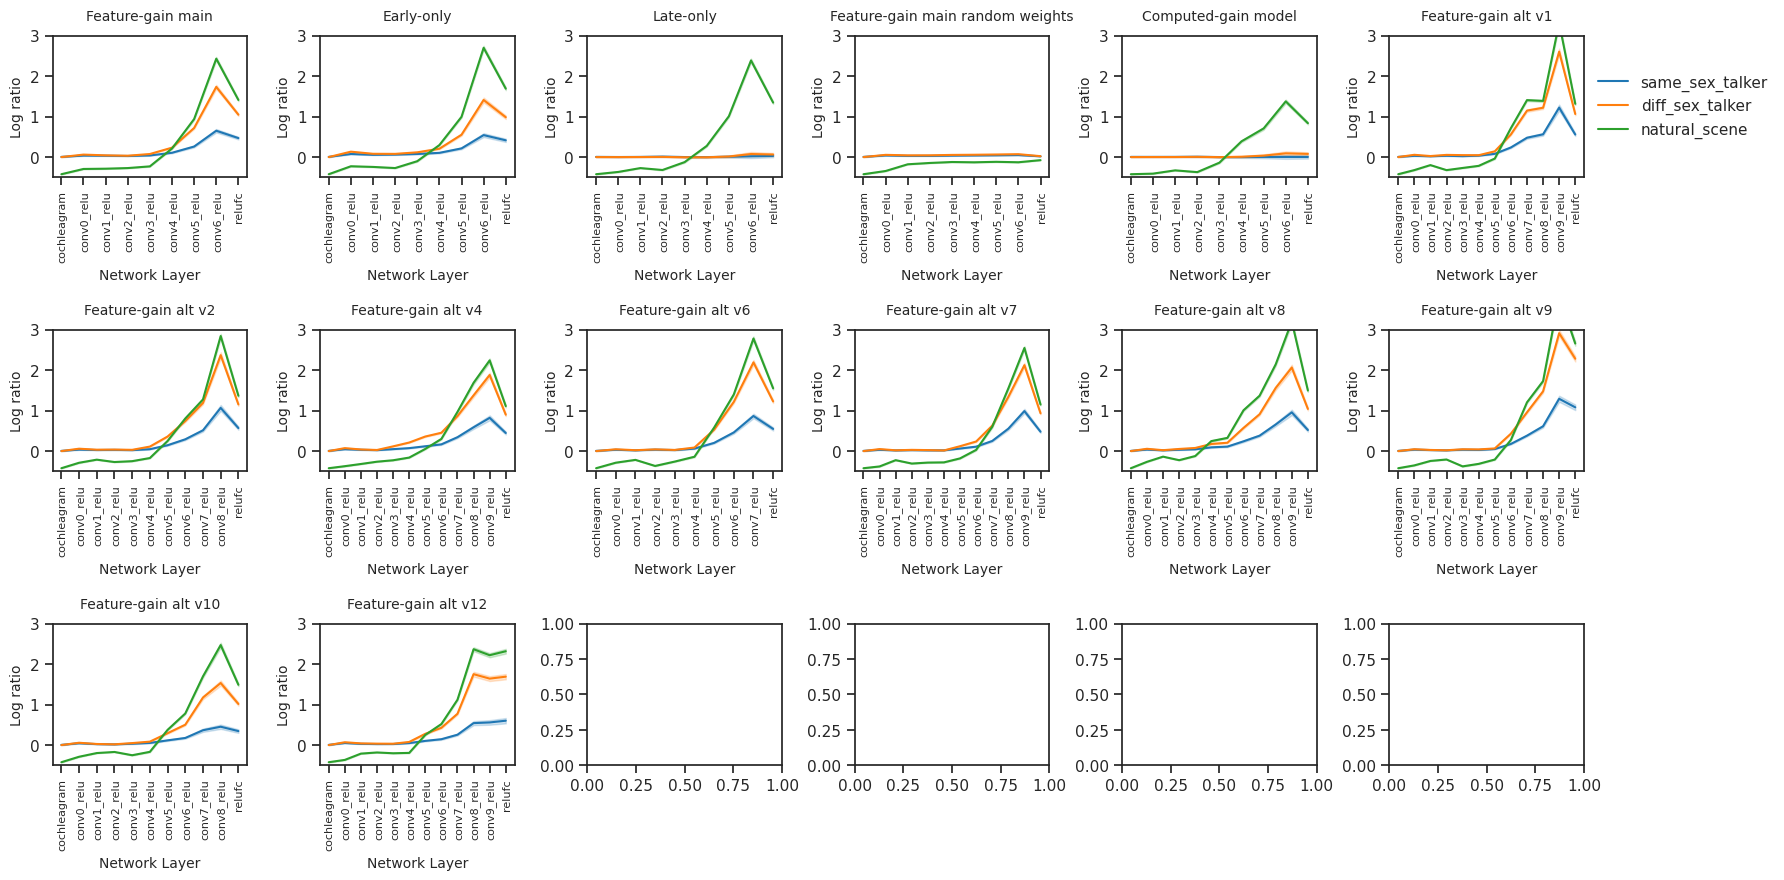

In [27]:
sns.set_context('notebook')

all_models = act_results['model_name'].unique()
n_models = len(all_models)

n_cols = 6
n_rows = int(np.ceil(n_models / n_cols))
panel_height = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols* panel_height , n_rows*panel_height), sharex=False, sharey=False)
axs = axs.flatten()

fontsize=10

model_order = ['Feature-gain main', 'Early-only','Late-only', "Feature-gain main random weights", 'Computed-gain model']
# nat sort the other archs 
also_sort = [m for m in all_models if m not in model_order]
model_order += sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))

for i, model in enumerate(model_order):
    model_for_panel = act_results[act_results['model_name'] == model].set_index('layer')
    layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
    model_for_panel = model_for_panel.loc[layers].reset_index()

    g = sns.lineplot(data=model_for_panel, x='layer', 
                     y="log_corr_ratio", hue='distractor_condition', ax=axs[i],
                     errorbar=('se', 1)
                    )

    axs[i].set_xlabel("Network Layer", size=fontsize)
    axs[i].set_ylabel("Log ratio", size=fontsize)
    axs[i].set_title(model, size=fontsize, y=1.05)

    axs[i].set(ylim=(-0.5, 3))

    if i != 5:
        axs[i].legend().remove()

    axs[i].set_xticks(range(len(layers)))
    axs[i].set_xticklabels(labels=layers, rotation=90, size=tick_fontsize, 
                           ha='right', va='center_baseline',  rotation_mode='anchor')
    
    axs[5].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title_fontsize=fontsize);
plt.tight_layout()

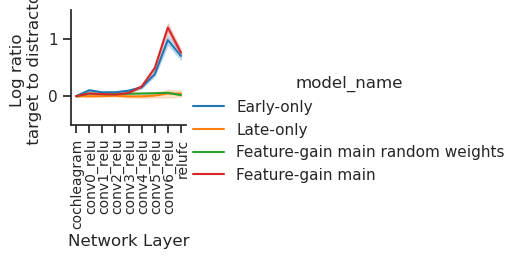

In [28]:
to_plot = act_results[act_results.model_name.str.contains('main|Early|Late|rand') & ~act_results.distractor_condition.str.contains('natural')].copy()
to_plot = to_plot.set_index('layer')
model = 'Feature-gain main'
layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
to_plot = to_plot.loc[layers].reset_index()
g = sns.relplot(data=to_plot, x='layer', y='log_corr_ratio', hue='model_name',  kind='line', errorbar=('ci', 95), seed=1, height=3)
# g.set_xticks(range(len(layers)))
g.set_xticklabels(labels=layers, rotation=90, size=fontsize, 
                        ha='right', va='center_baseline',  rotation_mode='anchor')

g.set_axis_labels("Network Layer", "Log ratio \n target to distractor")

# make apsect ratio 1
for ax in g.axes.flatten():
    ax.set_box_aspect(1)
    ax.set(ylim=(-0.5, 1.5))
    # remove spines
    sns.despine(ax=ax)

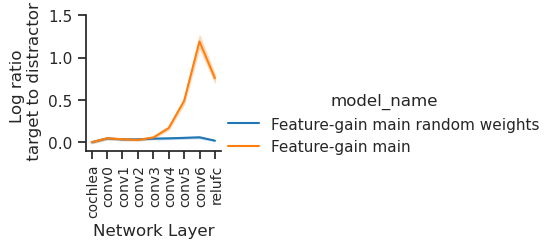

In [69]:
to_plot = act_results[act_results.model_name.str.contains('main|rand') & ~act_results.distractor_condition.str.contains('natural')].copy()
to_plot = to_plot.set_index('layer')
model = 'Feature-gain main'
layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
layer_names = ['cochlea' if 'cochlea' in l else l.split('_')[0] for l in layers]

to_plot = to_plot.loc[layers].reset_index()
g = sns.relplot(data=to_plot, x='layer', y='log_corr_ratio', hue='model_name',  kind='line', errorbar=('ci', 95), seed=1, height=3)
# g.set_xticks(range(len(layers)))
g.set_xticklabels(labels=layers, rotation=90, size=fontsize, 
                        ha='right', va='center_baseline',  rotation_mode='anchor')

g.set_axis_labels("Network Layer", "Log ratio \n target to distractor")
g.axes[0,0].set_xticklabels(labels=layer_names)
# make apsect ratio 1
for ax in g.axes.flatten():
    ax.set_box_aspect(1)
    ax.set(ylim=(-0.1, 1.5))
    # remove spines
    sns.despine(ax=ax)

### Make above plot, skipping all dead units 

In [29]:
results_dir = Path("binaural_unit_activation_analysis")
dead_unit_corrs = pd.concat([pd.read_pickle(pkl) for pkl in results_dir.glob("*/*skip_dead_units_full_rep.*pkl")])

speech_dist_corrs = dead_unit_corrs[dead_unit_corrs.distractor_condition != "Natural scene"].copy().reset_index(drop=True) 
speech_dist_corrs = speech_dist_corrs[~speech_dist_corrs.model_name.isin(["Baseline CNN", 'Feature-gain v10 '])]



In [40]:
speech_dist_corrs.distractor_condition.unique()

array(['Same sex', 'Different sex'], dtype=object)

In [30]:
results_dir = Path("binaural_unit_activation_analysis")
list(results_dir.glob("*/*skip_dead_units.*pkl"))

[PosixPath('binaural_unit_activation_analysis/word_task_late_only_v10/word_task_late_only_v10_corrs_skip_dead_units.pdpkl'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_1/word_task_v10_4MGB_ln_first_arch_1_corrs_skip_dead_units.pdpkl'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_10/word_task_v10_4MGB_ln_first_arch_10_corrs_skip_dead_units.pdpkl'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_12/word_task_v10_4MGB_ln_first_arch_12_corrs_skip_dead_units.pdpkl'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_2/word_task_v10_4MGB_ln_first_arch_2_corrs_skip_dead_units.pdpkl'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_4/word_task_v10_4MGB_ln_first_arch_4_corrs_skip_dead_units.pdpkl'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_6/word_task_v10_4MGB_ln_first_arch_6_corrs_skip_dead_unit

In [31]:
main_model_dead_unit_filt = speech_dist_corrs[speech_dist_corrs.model_name == 'Feature-gain main']
main_model_all_units = act_corrs[act_corrs.model_name == 'Feature-gain main']

In [32]:
main_model_dead_unit_filt.sort_values('layer', inplace=True)
main_model_all_units.sort_values('layer', inplace=True)

/tmp/ipykernel_3777291/3534133746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_model_dead_unit_filt.sort_values('layer', inplace=True)
/tmp/ipykernel_3777291/3534133746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_model_all_units.sort_values('layer', inplace=True)


In [33]:
import re
# Get layer order per model. Will have from [cochleagram, norm_coch_rep, ..., attnfc, relufc]
layer_order_dict = {}

def get_int(val):
    return int(re.search(r'\d+', val).group())

for model in speech_dist_corrs['model_name'].unique():
    layers = speech_dist_corrs.loc[speech_dist_corrs['model_name'] == model, 'layer'].unique()
    # sort by the number in the layer name
    layers_to_sort = [l for l in layers if not(any([str_part in l for str_part in ['fc', 'coch']]))]
    sorted_intermediate_layers = sorted(layers_to_sort, key=get_int)
    sorted_layers = ['cochleagram', 'norm_coch_rep'] + sorted_intermediate_layers
    if 'attnfc' in layers:
        sorted_layers.append('attnfc')
    sorted_layers.append('relufc')
    layer_order_dict[model] = sorted_layers


In [35]:
speech_dist_corrs

,layer,distractor_condition,model_name,Stream,sim_measure
0,hann_pool_5,Same sex,Early-only,"corr(target$_i$, mixture$_i$)",0.483948
1,hann_pool_5,Same sex,Early-only,"corr(target$_i$, mixture$_i$)",0.592219
2,hann_pool_5,Same sex,Early-only,"corr(target$_i$, mixture$_i$)",0.468338
3,hann_pool_5,Same sex,Early-only,"corr(target$_i$, mixture$_i$)",0.504242
4,hann_pool_5,Same sex,Early-only,"corr(target$_i$, mixture$_i$)",0.453171
...,...,...,...,...,...
3251995,hann_pool_1,Different sex,Feature-gain main random weights,"sim(distractor$_i$, mixture$_i$)",0.900849
3251996,hann_pool_1,Different sex,Feature-gain main random weights,"sim(distractor$_i$, mixture$_i$)",0.861833
3251997,hann_pool_1,Different sex,Feature-gain main random weights,"sim(distractor$_i$, mixture$_i$)",0.846025
3251998,hann_pool_1,Different sex,Feature-gain main random weights,"sim(distractor$_i$, mixture$_i$)",0.909151


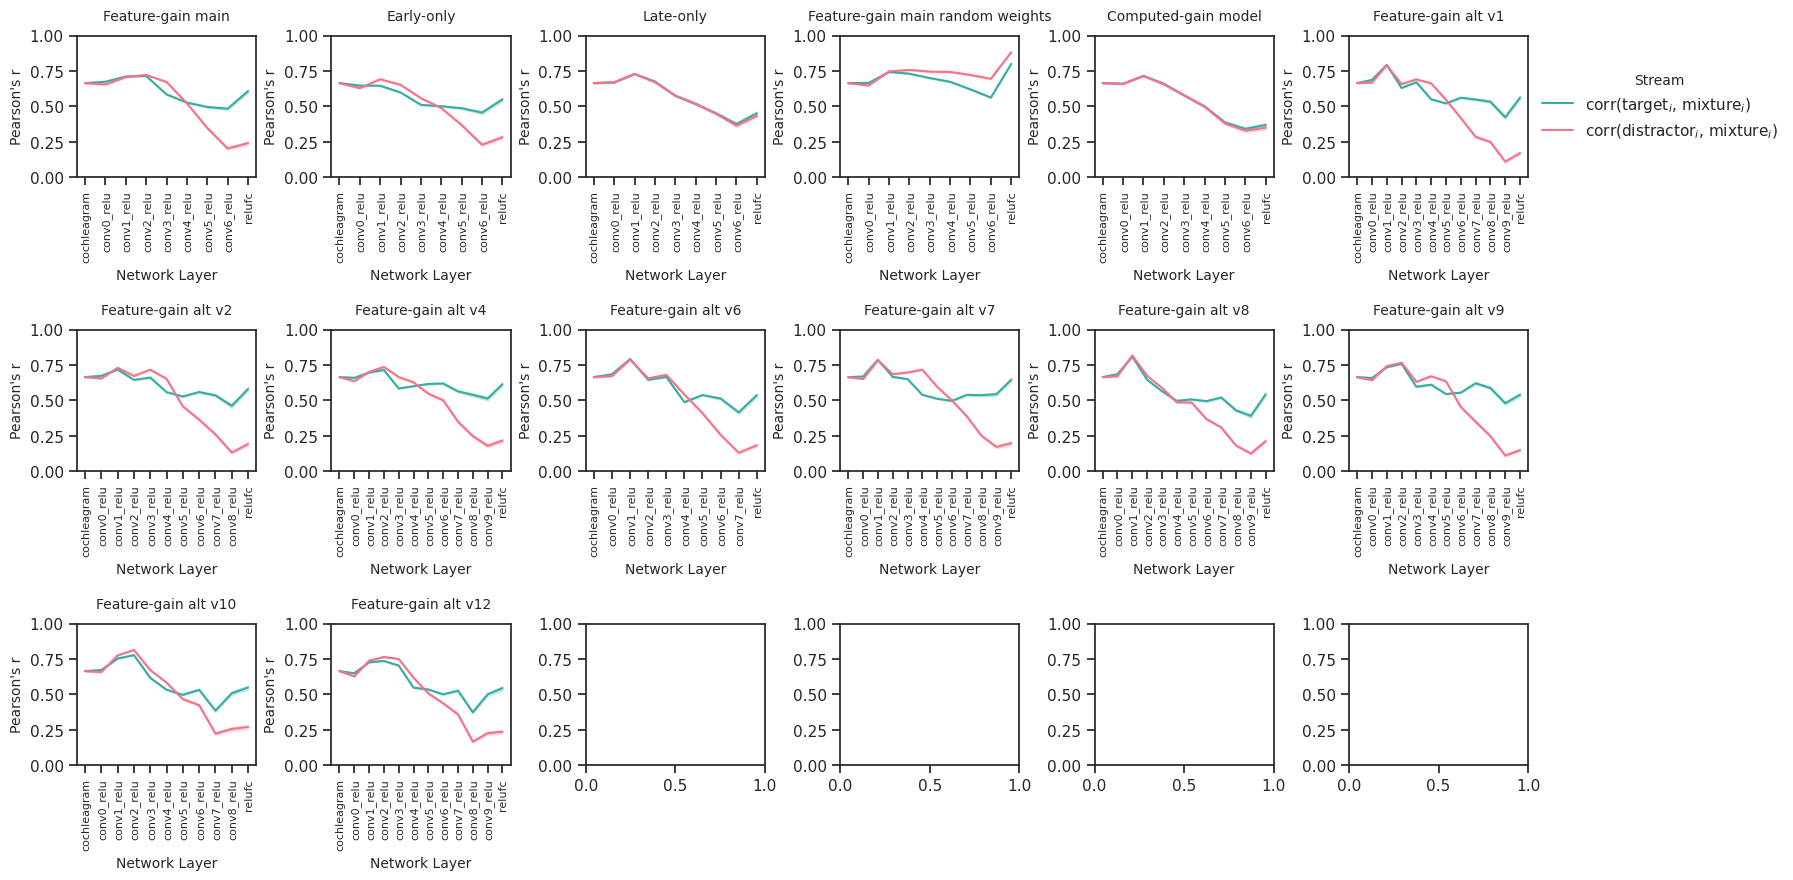

In [37]:
## Plot summary_results df 
sns.set_style('ticks')
# order = np.sort(results.layer.unique())

hue_order = ['corr(target$_i$, mixture$_i$)', 'corr(distractor$_i$, mixture$_i$)',]
            #    'corr(target$_i$, mixture$_i$) no dead units', 'corr(distractor$_i$, mixture$_i$) no dead units'] 

# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'corr(target$_i$, mixture$_i$)': palette[1],
                'corr(distractor$_i$, mixture$_i$)': palette[0],
                # 'corr(target$_i$, mixture$_i$) no dead units': 'turquoise',
                # 'corr(distractor$_i$, mixture$_i$) no dead units': 'gold',
                }
# add line style dict 
line_style_dict = {'corr(target$_i$, mixture$_i$)': '-',
                   'corr(distractor$_i$, mixture$_i$)': '-'}  
 
col_wrap = 3 
n_models = len(speech_dist_corrs['model_name'].unique())

n_cols = 6
n_rows = int(np.ceil(n_models / n_cols))
panel_height = 3
fontsize=10
tick_fontsize = 8


fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*panel_height, n_rows*panel_height), sharex=False, sharey=False)
axs = axs.flatten()


model_order = ['Feature-gain main', 'Early-only', 'Late-only', "Feature-gain main random weights", "Computed-gain model"]
# nat sort the other archs 
also_sort = [m for m in speech_dist_corrs['model_name'].unique() if m not in model_order]
model_order += sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))

for i, model in enumerate(model_order):
    to_plot = speech_dist_corrs[speech_dist_corrs['model_name'] == model].set_index('layer')
    layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
    to_plot = to_plot.loc[layers].reset_index()

    g = sns.lineplot(data=to_plot, x='layer', 
                     y="sim_measure", hue='Stream', ax=axs[i],
                     palette=palette_dict,  hue_order=hue_order,
                     errorbar=('ci', 95)
                    )

    axs[i].set_xlabel("Network Layer", size=fontsize)
    axs[i].set_ylabel("Pearson's r", size=fontsize)
    axs[i].set_title(model, size=fontsize, y=1.05)
    # p.axes[0,0].xaxis.labelpad = -0.25
    # set y limit to 0,1
    axs[i].set(ylim=(0,1))

    if i != 5:
        axs[i].legend().remove()

    axs[i].set_xticks(range(len(layers)))
    axs[i].set_xticklabels(labels=layers, rotation=90, size=tick_fontsize, 
                           ha='right', va='center_baseline',  rotation_mode='anchor')

axs[5].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Stream', frameon=False, title_fontsize=fontsize)
    
plt.tight_layout()

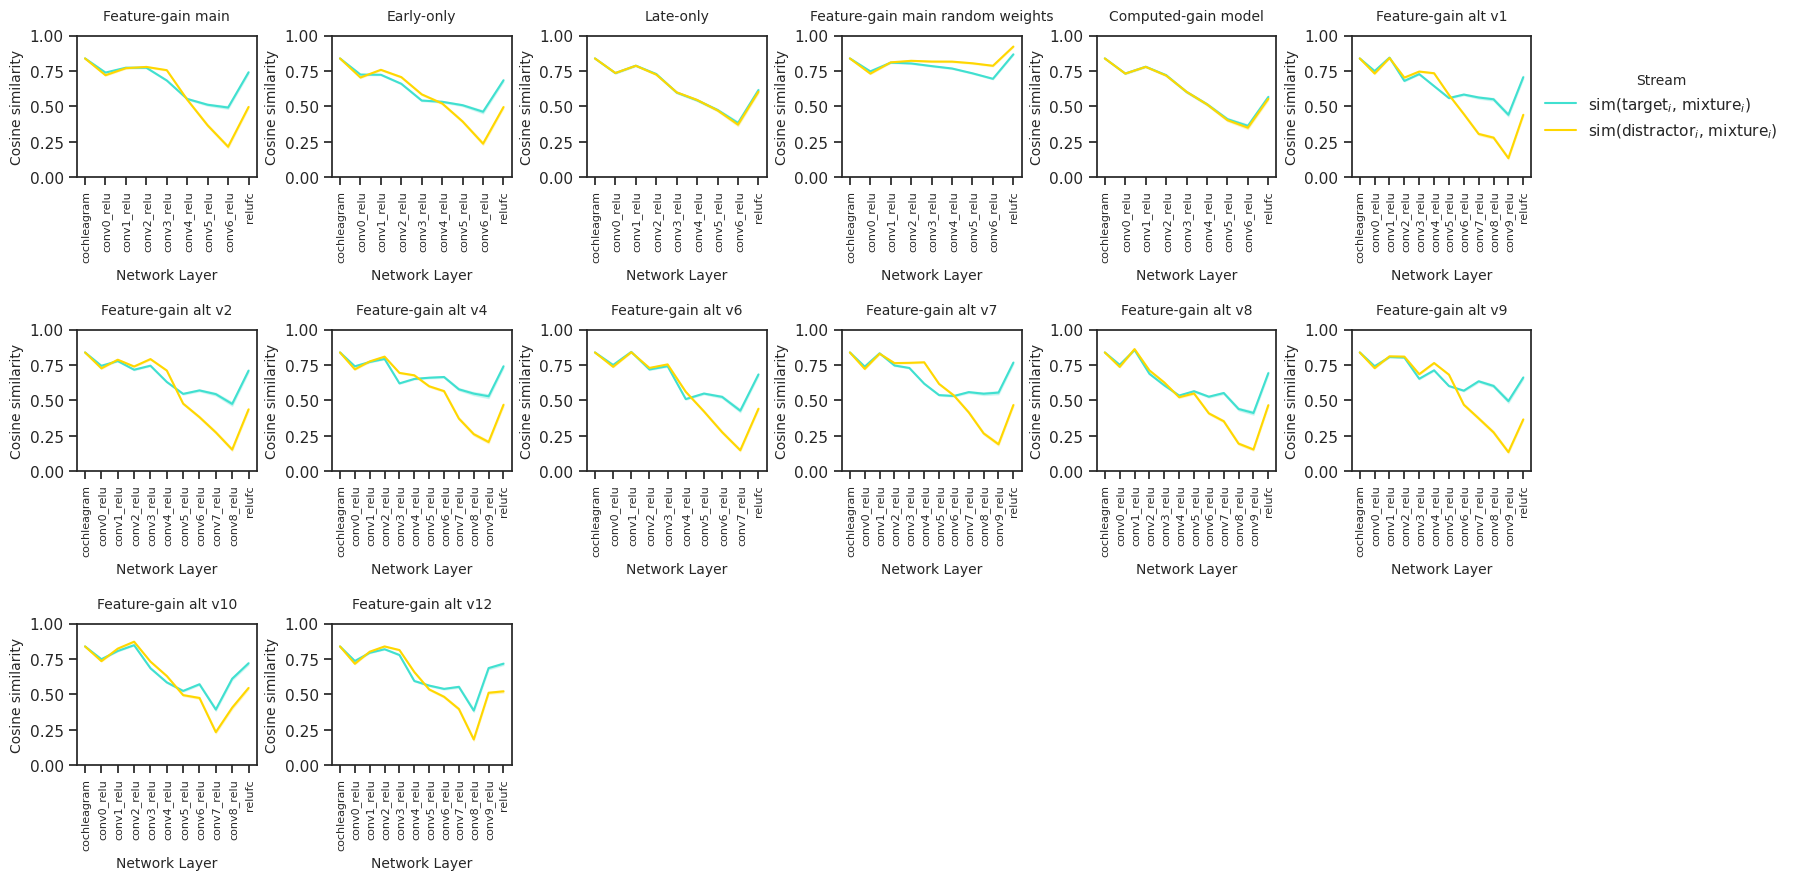

In [44]:
## Plot summary_results df 
sns.set_style('ticks')
# order = np.sort(results.layer.unique())

for_plot = speech_dist_corrs.copy()
for_plot = speech_dist_corrs[~speech_dist_corrs.Stream.str.contains('no dead units')]

# remove no dead units from stream
# for_plot['Stream'] = for_plot['Stream'].str.replace(' no dead units', '')


hue_order = ['sim(target$_i$, mixture$_i$)', 'sim(distractor$_i$, mixture$_i$)',]
            #    'corr(target$_i$, mixture$_i$) no dead units', 'corr(distractor$_i$, mixture$_i$) no dead units'] 

# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'sim(target$_i$, mixture$_i$)': 'turquoise',
                'sim(distractor$_i$, mixture$_i$)':'gold',
                # 'corr(target$_i$, mixture$_i$) no dead units': 'turquoise',
                # 'corr(distractor$_i$, mixture$_i$) no dead units': 'gold',
                }
# add line style dict 
line_style_dict = {'sim(target$_i$, mixture$_i$)': '-',
                   'sim(distractor$_i$, mixture$_i$)': '-'}  
 
n_models = len(for_plot['model_name'].unique())

n_cols = 6
n_rows = int(np.ceil(n_models / n_cols))
panel_height = 3
fontsize=10
tick_fontsize = 8


fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*panel_height, n_rows*panel_height), sharex=False, sharey=False)
axs = axs.flatten()


# model_order = ['Feature-gain main','Late-only' ] #  'Early-only',
# nat sort the other archs 
also_sort = [m for m in for_plot['model_name'].unique() if m not in model_order]
model_order += sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))

for i, model in enumerate(model_order):
    to_plot = for_plot[for_plot['model_name'] == model].set_index('layer')
    layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
    to_plot = to_plot.loc[layers].reset_index()

    g = sns.lineplot(data=to_plot, x='layer', 
                     y="sim_measure", hue='Stream', ax=axs[i],
                     palette=palette_dict,  hue_order=hue_order,
                     errorbar=('ci', 95)
                    )

    axs[i].set_xlabel("Network Layer", size=fontsize)
    axs[i].set_ylabel("Cosine similarity", size=fontsize)
    axs[i].set_title(model, size=fontsize, y=1.05)
    # p.axes[0,0].xaxis.labelpad = -0.25
    # set y limit to 0,1
    axs[i].set(ylim=(0,1))

    if i != 5:
        axs[i].legend().remove()

    axs[i].set_xticks(range(len(layers)))
    axs[i].set_xticklabels(labels=layers, rotation=90, size=tick_fontsize, 
                           ha='right', va='center_baseline',  rotation_mode='anchor')

axs[5].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Stream', frameon=False, title_fontsize=fontsize)
 
for ix, ax in enumerate(axs.ravel()):
    if ix >= n_models:
        ax.axis('off')   
plt.tight_layout()

/tmp/ipykernel_1243937/1457861937.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['Stream'] = for_plot['Stream'].str.replace(' no dead units', '')


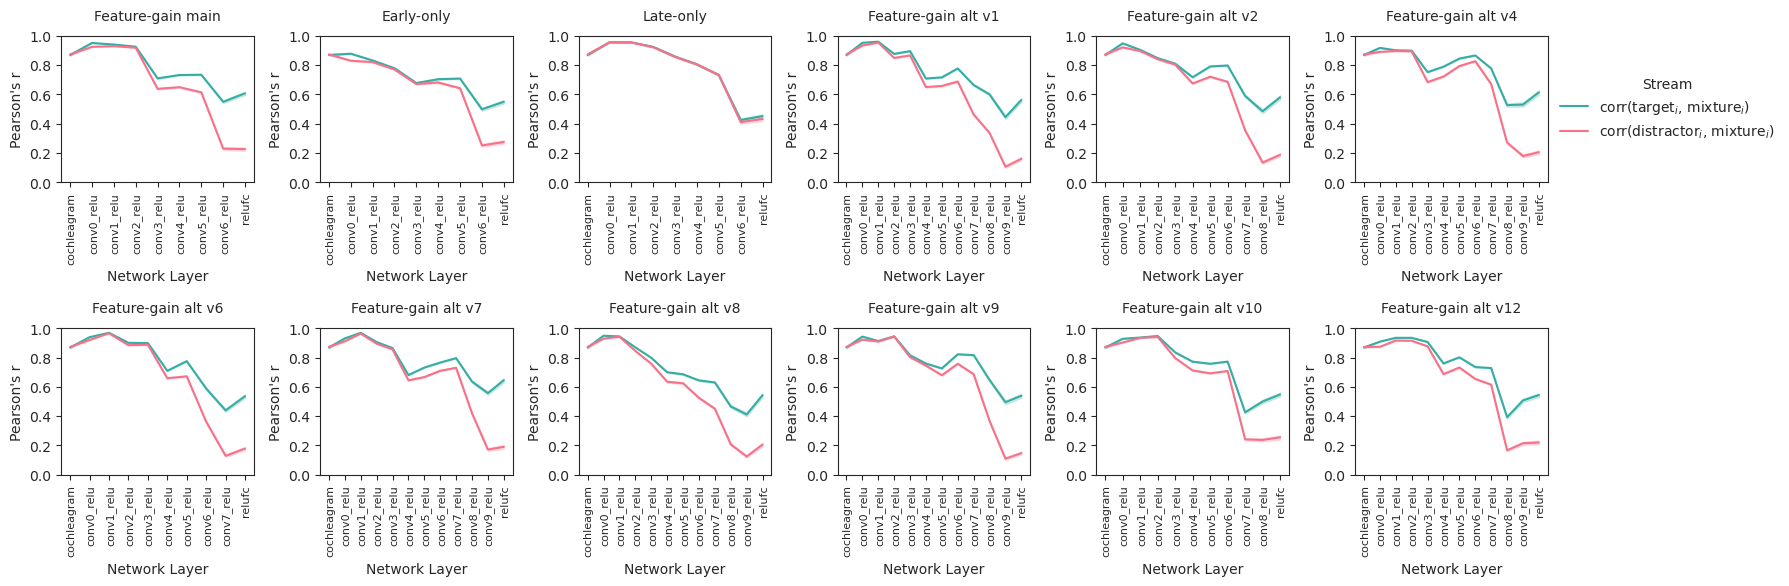

In [107]:
## Plot summary_results df 
sns.set_style('ticks')
# order = np.sort(results.layer.unique())

for_plot = speech_dist_corrs.copy()
for_plot = speech_dist_corrs[speech_dist_corrs.Stream.str.contains('no dead units')]

# remove no dead units from stream
for_plot['Stream'] = for_plot['Stream'].str.replace(' no dead units', '')


hue_order = ['corr(target$_i$, mixture$_i$)', 'corr(distractor$_i$, mixture$_i$)',]
            #    'corr(target$_i$, mixture$_i$) no dead units', 'corr(distractor$_i$, mixture$_i$) no dead units'] 

# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'corr(target$_i$, mixture$_i$)': palette[1],
                'corr(distractor$_i$, mixture$_i$)': palette[0],
                'corr(target$_i$, mixture$_i$) no dead units': 'turquoise',
                'corr(distractor$_i$, mixture$_i$) no dead units': 'gold',
                }
# add line style dict 
line_style_dict = {'corr(target$_i$, mixture$_i$)': '-',
                   'corr(distractor$_i$, mixture$_i$)': '-'}  
 
n_models = len(for_plot['model_name'].unique())

n_cols = 6
n_rows = int(np.ceil(n_models / n_cols))
panel_height = 3
fontsize=10
tick_fontsize = 8


fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*panel_height, n_rows*panel_height), sharex=False, sharey=False)
axs = axs.flatten()


model_order = ['Feature-gain main', 'Early-only','Late-only' ]
# nat sort the other archs 
also_sort = [m for m in for_plot['model_name'].unique() if m not in model_order]
model_order += sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))

for i, model in enumerate(model_order):
    to_plot = for_plot[for_plot['model_name'] == model].set_index('layer')
    layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
    to_plot = to_plot.loc[layers].reset_index()

    g = sns.lineplot(data=to_plot, x='layer', 
                     y="Pearson's r", hue='Stream', ax=axs[i],
                     palette=palette_dict,  hue_order=hue_order,
                     errorbar=('ci', 95)
                    )

    axs[i].set_xlabel("Network Layer", size=fontsize)
    axs[i].set_ylabel("Pearson's r", size=fontsize)
    axs[i].set_title(model, size=fontsize, y=1.05)
    # p.axes[0,0].xaxis.labelpad = -0.25
    # set y limit to 0,1
    axs[i].set(ylim=(0,1))

    if i != 5:
        axs[i].legend().remove()

    axs[i].set_xticks(range(len(layers)))
    axs[i].set_xticklabels(labels=layers, rotation=90, size=tick_fontsize, 
                           ha='right', va='center_baseline',  rotation_mode='anchor')

axs[5].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Stream', frameon=False, title_fontsize=fontsize)
    
plt.tight_layout()

In [108]:
### Plot dimensionality of layers per model 

shape_dicts = list(analysis_dir.glob("*/*layer_shape_dict_time_avg.*pkl"))
shape_dicts

models_to_plot = []

for path in shape_dicts:

    if 'main' in path.stem and not ('latest' in path.stem or 'random' in path.stem):
        continue 
    if 'control' in path.stem:
        continue

    models_to_plot.append(path)
models_to_plot

[PosixPath('binaural_unit_activation_analysis/word_task_early_only_v10/word_task_early_only_v10_layer_shape_dict_time_avg.pkl'),
 PosixPath('binaural_unit_activation_analysis/word_task_late_only_v10/word_task_late_only_v10_layer_shape_dict_time_avg.pkl'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_1/word_task_v10_4MGB_ln_first_arch_1_layer_shape_dict_time_avg.pkl'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_10/word_task_v10_4MGB_ln_first_arch_10_layer_shape_dict_time_avg.pkl'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_12/word_task_v10_4MGB_ln_first_arch_12_layer_shape_dict_time_avg.pkl'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_2/word_task_v10_4MGB_ln_first_arch_2_layer_shape_dict_time_avg.pkl'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_4/word_task_v10_4MGB_ln_first_arch_4_layer_shape_dict_time_avg.pk

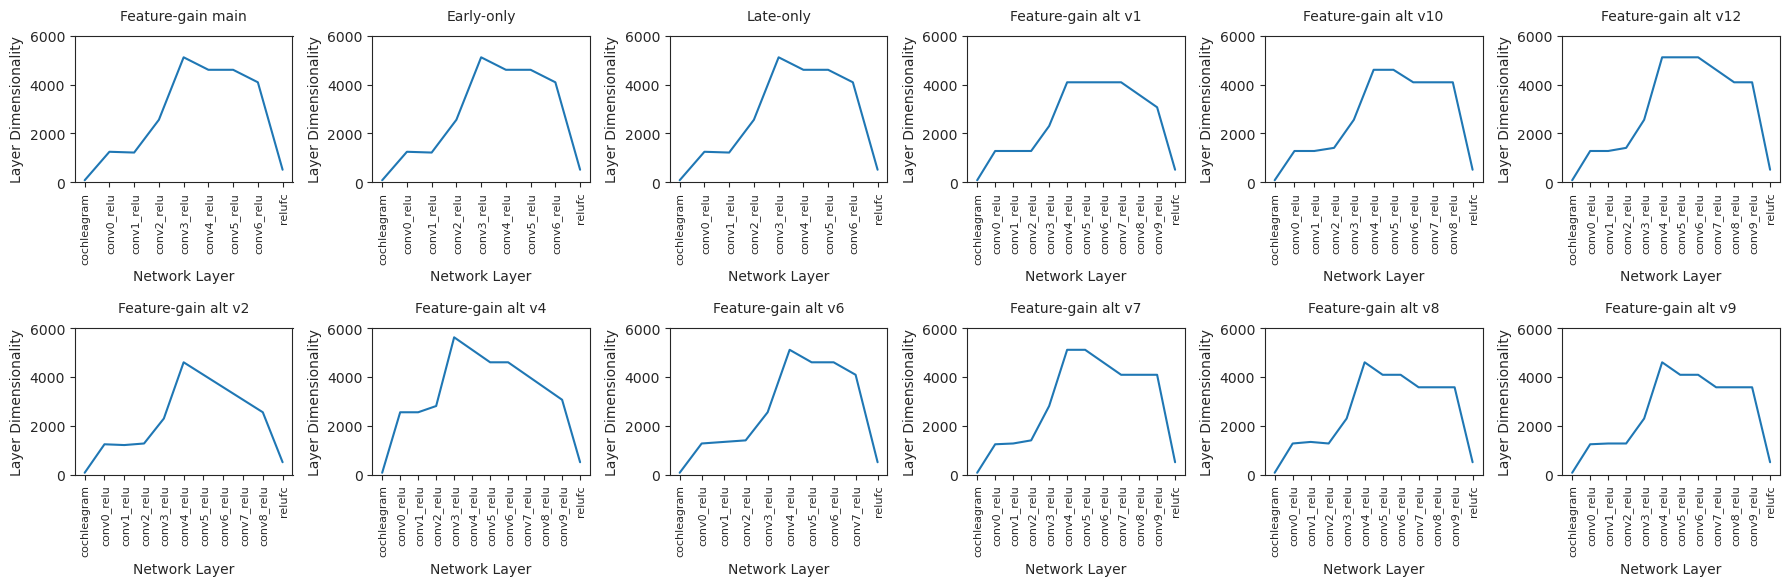

In [130]:
path_order = [
                Path('binaural_unit_activation_analysis/word_task_v10_main_feature_gain_config_latest_ckpt/word_task_v10_main_feature_gain_config_latest_ckpt_layer_shape_dict_time_avg.pkl'),
                Path('binaural_unit_activation_analysis/word_task_early_only_v10/word_task_early_only_v10_layer_shape_dict_time_avg.pkl'),
                Path('binaural_unit_activation_analysis/word_task_late_only_v10/word_task_late_only_v10_layer_shape_dict_time_avg.pkl'),
                Path('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_1/word_task_v10_4MGB_ln_first_arch_1_layer_shape_dict_time_avg.pkl'),
                Path('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_10/word_task_v10_4MGB_ln_first_arch_10_layer_shape_dict_time_avg.pkl'),
                Path('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_12/word_task_v10_4MGB_ln_first_arch_12_layer_shape_dict_time_avg.pkl'),
                Path('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_2/word_task_v10_4MGB_ln_first_arch_2_layer_shape_dict_time_avg.pkl'),
                Path('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_4/word_task_v10_4MGB_ln_first_arch_4_layer_shape_dict_time_avg.pkl'),
                Path('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_6/word_task_v10_4MGB_ln_first_arch_6_layer_shape_dict_time_avg.pkl'),
                Path('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_7/word_task_v10_4MGB_ln_first_arch_7_layer_shape_dict_time_avg.pkl'),
                Path('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_8/word_task_v10_4MGB_ln_first_arch_8_layer_shape_dict_time_avg.pkl'),
                Path('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_9/word_task_v10_4MGB_ln_first_arch_9_layer_shape_dict_time_avg.pkl'),
 ]


n_models = len(for_plot['model_name'].unique())

n_cols = 6
n_rows = int(np.ceil(n_models / n_cols))
panel_height = 3
fontsize=10
tick_fontsize = 8


fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*panel_height, n_rows*panel_height), sharex=False, sharey=False)
axs = axs.flatten()

## Set plot order 


for i, model_dict_path in enumerate(path_order):
    shape_dict = pd.read_pickle(model_dict_path)
    shape_dict = {k.replace('_block_', ''): v for k,v in shape_dict.items()}
    model = get_model_name(model_dict_path.stem.split('_layer')[0])
    layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
    layer_dims = [np.prod(shape_dict['norm_coch_rep'][1:3]) if 'cochlea' in l else np.prod(shape_dict[l][1:3]) for l in layers]

    axs[i].plot(layer_dims)
    axs[i].set_title(model, size=fontsize, y=1.05)
    axs[i].set_xticks(range(len(layers)))
    axs[i].set_xticklabels(labels=layers, rotation=90, size=tick_fontsize, 
                           ha='right', va='center_baseline',  rotation_mode='anchor')
    axs[i].set_ylabel('Layer Dimensionality', size=fontsize)
    axs[i].set_xlabel('Network Layer', size=fontsize)
    axs[i].set_ylim(0, 6000)

plt.tight_layout()

In [24]:
models_to_run

[PosixPath('binaural_unit_activation_analysis/word_task_early_only_v10'),
 PosixPath('binaural_unit_activation_analysis/word_task_late_only_v10'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_1'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_10'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_12'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_2'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_4'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_6'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_7'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_8'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_4MGB_ln_first_arch_9'),
 PosixPath('binaural_unit_activation_analysis/word_task_v10_main_feature_gain_config_latest_ckp

In [3]:
# Written by R. Preston Hess - convrted to numpy by Ian M. Griffith. 

def cka(feats_A, feats_B, kernel_metric='ip', rbf_sigma=1.0, unbiased=False):
    """Computes the unbiased Centered Kernel Alignment (CKA) between features."""
    if kernel_metric == 'ip':
        # Compute kernel matrices for the linear case
        K = np.dot(feats_A, feats_A.T)
        L = np.dot(feats_B, feats_B.T)
    elif kernel_metric == 'rbf':
        # COMPUTES RBF KERNEL
        K = np.exp(-np.square(np.linalg.norm(feats_A[:, None] - feats_A, axis=2)) / (2 * rbf_sigma ** 2))
        L = np.exp(-np.square(np.linalg.norm(feats_B[:, None] - feats_B, axis=2)) / (2 * rbf_sigma ** 2))
    else:
        raise ValueError(f"Invalid kernel metric {kernel_metric}")
    # Compute HSIC values
    hsic_fn = hsic_unbiased if unbiased else hsic_biased
    hsic_kk = hsic_fn(K, K)
    hsic_ll = hsic_fn(L, L)
    hsic_kl = hsic_fn(K, L)
    # Compute CKA
    cka_value = hsic_kl / (np.sqrt(hsic_kk * hsic_ll) + 1e-6)
    return cka_value

def unbiased_cka(*args, **kwargs):
    kwargs['unbiased'] = True
    return cka(*args, **kwargs)

def hsic_unbiased(K, L):
    """
    Compute the unbiased Hilbert-Schmidt Independence Criterion (HSIC) as per Equation 5 in the paper.
    > Reference: https://jmlr.csail.mit.edu/papers/volume13/song12a/song12a.pdf
    """
    m = K.shape[0]
    # Zero out the diagonal elements of K and L
    K_tilde = K.copy()
    np.fill_diagonal(K_tilde, 0)
    L_tilde = L.copy()
    np.fill_diagonal(L_tilde, 0)
    # Compute HSIC using the formula in Equation 5
    HSIC_value = (
        (np.sum(K_tilde * L_tilde.T))
        + (np.sum(K_tilde) * np.sum(L_tilde) / ((m - 1) * (m - 2)))
        - (2 * np.sum(np.dot(K_tilde, L_tilde)) / (m - 2))
    )
    HSIC_value /= m * (m - 3)
    return HSIC_value

def hsic_biased(K, L):
    """ Compute the biased HSIC (the original CKA) """
    H = np.eye(K.shape[0]) - 1 / K.shape[0]
    return np.trace(K @ H @ L @ H)


In [4]:
# dev with one model 

model_dir = Path('binaural_unit_activation_analysis/word_task_v10_main_feature_gain_config_latest_ckpt')

h5_fn = 'binaural_unit_activation_analysis/word_task_v10_main_feature_gain_config_latest_ckpt/word_task_v10_main_feature_gain_config_latest_ckpt_model_activations_0dB_diotic.h5'
with h5py.File(h5_fn, 'r') as acts:
    layer_names = set([l.split('_target')[0] for l in acts.keys() if 'target' in l and 'relu' in l and not  any([str_part in l for str_part in ['_f0', '_loc', '_word', 'cued']])]) # set to remove duplicates 

    measures = [] 
    for layer in layer_names:
        print(layer)
        fg_key = f"{layer}_cued_target"
        bg_key = f"{layer}_cued_same_sex_dist"
        mix_key = f"{layer}_mixture_same"

        fg_acts = acts[fg_key][:]
        bg_acts = acts[bg_key][:]
        mix_acts = acts[mix_key][:]

        tgt_mix_cka = cka(fg_acts, mix_acts, unbiased=True)
        dist_mix_cka = cka(bg_acts, mix_acts, unbiased=True)
        record = {
            'layer': layer,
            'tgt_mix_cka': tgt_mix_cka,
            'dist_mix_cka': dist_mix_cka
        }
        print(record)
        measures.append(record)


conv_block_2_relu
{'layer': 'conv_block_2_relu', 'tgt_mix_cka': 0.6506322807763311, 'dist_mix_cka': 0.6001783429982934}
conv_block_3_relu
{'layer': 'conv_block_3_relu', 'tgt_mix_cka': 0.8039244220456244, 'dist_mix_cka': 0.7680331424613472}
conv_block_5_relu
{'layer': 'conv_block_5_relu', 'tgt_mix_cka': 0.5166534538583941, 'dist_mix_cka': 0.3213571181114039}
relufc
{'layer': 'relufc', 'tgt_mix_cka': 0.40100012748740615, 'dist_mix_cka': 0.12247956842624708}
conv_block_0_relu


: 

: 

: 

In [13]:
cka(bg_acts, mix_acts, unbiased=True)

0.7680331424613472

In [ ]:
cka(fg_acts, mix_acts, unbiased=True), 

0.8039244220456244